<a href="https://colab.research.google.com/github/mia19reynolds/FinalProject/blob/main/SyntheticStudentProfileGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Student Profile Generation

In this notebook, we implement a data generation pipeline for creating a synthetic dataset of student profiles designed to mirror the real characteristics and demographics of students attending secondary schools in Derbyshire.

All source data used in this notebook is obtained from the Department for Education (DfE) - please see references at the end of the notebook. Key distributions are extracted and normalized into two-dimensional pivot tables, which are then used in an iterative proportional fitting (IPF) process to generate joint distributions across seven core attributes. Using these, we sample 41,334 synthetic student profiles—the actual number of secondary pupils in Derbyshire.

The validation process involves comparing combinations of attribute categories in the synthetic dataset against the original real-world distributions to ensure fidelity.

An additive, no-intercept linear attendance model (with noise) is then fitted using real absence averages, and applied to the IPF-generated students to assign a continuous attendance value.

Finally, the resulting synthetic dataset is used to train and benchmark several machine learning models on the task of CIN (Children in Need) classification. Among these, a LightGBM model was found to perform best; this model is subsequently optimized and validated using appropriate performance metrics.

## Notebook Structure

This is a high level walk through of this project's note book.

1. **Data Loading & Preprocessing (Base Attributes)**  
   Importing, cleaning, and structuring DfE data regarding all demographic attributes into uniform pivot tables.

2. **Synthetic Data Generation via IPF**  
   The constuctived pivot tables are fed to IPF to create a joint distribution, which is used to sample the synthetic students accordingly.

3. **Validation & Error Metrics**  
   Comparing real vs. synthetic distributions (1D and 2D), and reporting overall errors on the generated attributes.

4. **Data Loading & Preprocessing (Attendance Attributes)**  
   Importing, cleaning, and structuring DfE data regarding absense into uniform pivot tables.

5. **Attendance Modeling**  
   Assigning continuous attendance values using an additive linear model with noise and the preprocessed absense pivot tables.

6. **Validation & Error Metrics**  
   Comparing real vs. synthetic distributions (1D and 2D), and reporting overall errors on the attendance averages.

7. **References**  
   Sources for all data used in this notebook.


# Imports

In [320]:
!pip install ipfn pyipf

In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipfn import ipfn
import random
from sklearn.linear_model import LinearRegression

## Normalize Master Dictionaries

In [322]:
# Labels in master order:
ethnicities_master = [
    "White - White British",
    "White - Any other White background",
    "Unclassified",
    "Mixed - White and Black Caribbean",
    "Mixed - White and Asian",
    "Mixed - Any other Mixed background",
    "Asian - Indian",
    "Black - Black African",
    "Asian - Chinese",
    "Mixed - White and Black African",
    "Asian - Any other Asian background",
    "Any other ethnic group",
    "Asian - Pakistani",
    "White - Irish",
    "Black - Any other Black background",
    "Black - Black Caribbean",
    "White - Gypsy/Roma",
    "Asian - Bangladeshi",
    "White - Traveller of Irish heritage"
]

# Map raw variant into one of those:
raw_to_master = {
    # White British
    "English / Welsh / Scottish / Northern Irish / British":"White - White British",
    "White - White British":"White - White British",
    "white_white_british":"White - White British",
    "white_british":"White - White British",
    'White British':"White - White British",

    # White other
    "Any other White background":"White - Any other White background",
    "White - Any other White background":"White - Any other White background",
    "white_any_other_white_background":"White - Any other White background",
    "any_other_white_background":"White - Any other White background",
    'Any other white background':"White - Any other White background",
    "Any other white background":"White - Any other White background",
    "Any other white background":"White - Any other White background",

    # Unclassified
    "Ethnicity Unclassified":"Unclassified",
    "Unclassified":"Unclassified",
    "unclassified":"Unclassified",

    # Mixed - W&BC
    "White and Black Caribbean":"Mixed - White and Black Caribbean",
    "Mixed - White and Black Caribbean":"Mixed - White and Black Caribbean",
    "mixed_white_and_black_caribbean":"Mixed - White and Black Caribbean",
    "Mixed - White and Black Carribean":"Mixed - White and Black Caribbean",
    "white_and_black_caribbean":"Mixed - White and Black Caribbean",
    "Mixed - White and Black Carribean":"Mixed - White and Black Caribbean",
    'White and Black Caribbean':"Mixed - White and Black Caribbean",

    # Mixed - W&A
    "White and Asian":"Mixed - White and Asian",
    "Mixed - White and Asian":"Mixed - White and Asian",
    "mixed_white_and_asian":"Mixed - White and Asian",
    "white_and_asian":"Mixed - White and Asian",

    # Mixed - other
    "Any other Mixed / Multiple ethnic background":"Mixed - Any other Mixed background",
    "Mixed - Any other Mixed background":"Mixed - Any other Mixed background",
    "mixed_any_other_mixed_background":"Mixed - Any other Mixed background",
    "any_other_mixed_background":"Mixed - Any other Mixed background",
    'Any other Mixed background':"Mixed - Any other Mixed background",
    "Any other mixed background":"Mixed - Any other Mixed background",

    # Mixed - W&BA
    "White and Black African":"Mixed - White and Black African",
    "Mixed - White and Black African":"Mixed - White and Black African",
    "mixed_white_and_black_african":"Mixed - White and Black African",
    "white_and_black_african": "Mixed - White and Black African",
    'White and Black African': "Mixed - White and Black African",

    # Asian - Indian
    "Indian":"Asian - Indian",
    "Asian - Indian":"Asian - Indian",
    "asian_indian":"Asian - Indian",
    "indian":"Asian - Indian",

    # Asian - Chinese
    "Chinese":"Asian - Chinese",
    "Asian - Chinese":"Asian - Chinese",
    "asian_chinese":"Asian - Chinese",
    "chinese":"Asian - Chinese",

    # Asian - other
    "Any other Asian background":"Asian - Any other Asian background",
    "Asian - Any other Asian background":"Asian - Any other Asian background",
    "asian_any_other_asian_background":"Asian - Any other Asian background",
    "any_other_asian_background":"Asian - Any other Asian background",

    # Asian -
    "Pakistani":"Asian - Pakistani",
    "Asian - Pakistani":"Asian - Pakistani",
    "asian_pakistani":"Asian - Pakistani",
    "pakistani":"Asian - Pakistani",

    # Asian - Bangladeshi
    "Bangladeshi":"Asian - Bangladeshi",
    "Asian - Bangladeshi":"Asian - Bangladeshi",
    "asian_bangaladeshi":"Asian - Bangladeshi",
    "bangladeshi":"Asian - Bangladeshi",
    "Asian - Bangaladeshi":"Asian - Bangladeshi",

    # Other ethnic group
    "Any other ethnic group":"Any other ethnic group",
    "Any other ethnic group":"Any other ethnic group",
    'Any Other Ethnic Group':"Any other ethnic group",
    "any_other_ethnic_group":"Any other ethnic group",

    # White - Irish
    "Irish":"White - Irish",
    "White - Irish":"White - Irish",
    "white_irish":"White - Irish",
    "irish":"White - Irish",
    "White Irish":"White - Irish",

    # Black - BA
    "African":"Black - Black African",
    "Black - Black African":"Black - Black African",
    "black_black_african":"Black - Black African",
    "black_african":"Black - Black African",
    'Black African':"Black - Black African",

    # Black -
    "Any other Black / African / Caribbean background":"Black - Any other Black background",
    "African":"Black - Black African",
    "Black - Any other Black background":"Black - Any other Black background",
    "black_any_other_black_background":"Black - Any other Black background",
    "any_other_black_background":"Black - Any other Black background",
    "Any other black background":"Black - Any other Black background",
    "Any other Black background":"Black - Any other Black background",

    # Black - BC
    "Caribbean":"Black - Black Caribbean",
    "Black - Black Caribbean":"Black - Black Caribbean",
    "black_caribbean":"Black - Black Caribbean",
    'Black Caribbean':"Black - Black Caribbean",

    # White - Gypsy/Roma
    "Gypsy / Roma":"White - Gypsy/Roma",
    "White - Gypsy/Roma":"White - Gypsy/Roma",
    "white_gypsy_roma":"White - Gypsy/Roma",
    "gypsy_roma":"White - Gypsy/Roma",
    "Gypsy Roma":"White - Gypsy/Roma",

    # Traveller
    "Traveller of Irish heritage":"White - Traveller of Irish heritage",
    "White - Traveller of Irish heritage":"White - Traveller of Irish heritage",
    "white_traveller_of_irish_heritage":"White - Traveller of Irish heritage",
    "traveller_of_irish_heritage":"White - Traveller of Irish heritage",
    "Traveller of Irish heritage":"White - Traveller of Irish heritage",

    'Gypsy or Irish Traveller':'Gypsy or Irish Traveller',
}


In [323]:
years   = ['Year 7','Year 8','Year 9','Year 10','Year 11']
eths    = ethnicities_master
fsms    = ['FSM_Eligible','FSM_Not_Eligible']
sens    = ['EHC plans','No SEN','SEN Support']
susp    = ['Not Suspended','Suspended']
genders = ['Female','Male']
cin     = ['No CIN','CIN']

# Distributions

## Data Preprocessing and Pivot Table Construction

In this section, raw Department for Education (DfE) datasets are preprocessed to create structured pivot tables of key student attributes. Using groupby and aggregation methods, a series of one-dimensional and two-dimensional pivot tables are created to captue the marginal and joint distributions of demographic and educational characteristics. These pivot tables serve as the foundation for the synthetic student data generation process, ensuring that all key relationships in the real data are accurately reflected in the synthetic population.

The following pivot tables are generated for each attribute in order:

Year Group


*   Year Group x Gender

Ethnicity

*   Overall Ethnicity

Free School Meals (FSM)

*   Overall FSM
*   FSM x Ethnicity
*   FSM x Year Group

Special Educational Needs (SEN)

*   Overall SEN
*   SEN x Gender
*   SEN x Year Group
*   SEN x Ethnicity
*   SEN x FSM

Suspensions

*   Suspensions Overall
*   Suspensions x Gender
*   Suspensions x FSM
*   Suspensions x SEN
*   Suspensions x Year Group
*   Suspensions x Ethnicity

Children In Need (CIN)

*   CIN Overall
*   CIN x Gender
*   CIN x Ethnicity
*   CIN x FSM
*   CIN x SEN
*   CIN x Suspension






















## Year Group

### Number of Students - Gender by Year Group

In [324]:
sex_ncyear_df = pd.read_csv('/content/drive/MyDrive/pupildata/yrgp_sex_secondary_derbyshire.csv')

# Column names
print("Columns in the Derbyshire dataset:")
print(sex_ncyear_df.columns.tolist())

# Display
print("First few rows:")
sex_ncyear_df.head()


Columns in the Derbyshire dataset:
['time_period', 'time_identifier', 'geographic_level', 'country_code', 'country_name', 'region_name', 'region_code', 'old_la_code', 'la_name', 'new_la_code', 'phase_type_grouping', 'sex', 'ncyear', 'headcount']
First few rows:


,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,sex,ncyear,headcount
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 10,3900
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 11,3956
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 7,4215
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 8,4178
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 9,4137


In [325]:
# Only keep necessary columns
df_gender_counts = sex_ncyear_df[['sex', 'ncyear', 'headcount']]

# Create a pivot table with sums
year_gender_pivot = df_gender_counts.pivot_table(
    index='ncyear',
    columns='sex',
    values='headcount',
    aggfunc='sum',
    fill_value=0
)

# Rename
year_gender_pivot.index.name = 'Year'
year_gender_pivot.columns.name = 'Gender'

# Print total headcount by gender
totals = df_gender_counts.groupby('sex')['headcount'].sum()
print("Headcount by Gender:")
print(totals.to_dict())
print()

gender_counts = totals

# Display
print("Headcount by Year within each Gender:")
display(year_gender_pivot)


Headcount by Gender:
{'Female': 20386, 'Male': 20948}

Headcount by Year within each Gender:


Gender,Female,Male
Year,,
Year 10,3900,4013
Year 11,3956,4128
Year 7,4215,4317
Year 8,4178,4336
Year 9,4137,4154


In [326]:
P_year_gender = year_gender_pivot.values.astype(float)
P_year_gender /= P_year_gender.sum()

## Ethnicity

### Number of Pupils per Ethnicity

In [327]:
ethnicity_df = pd.read_csv('/content/drive/MyDrive/pupildata/ethnicity_secondary_derbyshire.csv')
ethnicity_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,ethnicity_minor,language,headcount
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Any other ethnic group,Total,143
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Any other Asian background,Total,201
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Bangladeshi,Total,15
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Chinese,Total,213
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Indian,Total,387


In [328]:
# Map and fill missing
ethnicity_df['ethnicity'] = ethnicity_df['ethnicity_minor'].map(raw_to_master).fillna(ethnicity_df['ethnicity_minor'])

# Pivot
eth_pivot = (
    ethnicity_df
        .groupby('ethnicity')['headcount']
        .sum()
        .reset_index()
        .sort_values('headcount', ascending=False)
        .rename(columns={'ethnicity': 'Ethnicity'})
        .set_index('Ethnicity')
        .reindex(ethnicities_master, fill_value=0)
)

display(eth_pivot.head(20))


,headcount
Ethnicity,
White - White British,41377
White - Any other White background,1279
Unclassified,519
Mixed - White and Black Caribbean,476
Mixed - White and Asian,465
Mixed - Any other Mixed background,414
Asian - Indian,387
Black - Black African,306
Asian - Chinese,213


In [329]:
P_eth = eth_pivot['headcount'].astype(float).values
P_eth /= P_eth.sum()

## FSM

### Number of pupils with FSM

In [330]:
fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/fsm_secondary_derbyshire.csv')

fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,fsm,headcount
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,known to be eligible for free school meals (us...,11089
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,number of pupils (used for FSM in Performance ...,41304


In [331]:
# Eligible vs non Eligible

pivot_fsm = fsm_df.pivot_table(
    index='fsm',
    values='headcount',
    aggfunc='sum'
).rename(index={
    'known to be eligible for free school meals (used for FSM in Performance Tables)':
        'FSM_Eligible',
    'number of pupils (used for FSM in Performance Tables)':
        'TOTAL_PUPILS'
})
pivot_fsm.index.name = 'FSM_Status'

eligible     = pivot_fsm.loc['FSM_Eligible','headcount']
total_pupils = pivot_fsm.loc['TOTAL_PUPILS','headcount']
not_eligible = total_pupils - eligible

# Build Pivot
pivot_fsm = pd.Series({
    'FSM_Eligible':      eligible,
    'FSM_Not_Eligible':  not_eligible
}, name='headcount')

print("Clean FSM counts:")
display(pivot_fsm)

Clean FSM counts:


,headcount
FSM_Eligible,11089
FSM_Not_Eligible,30215


In [332]:
P_fsm = pivot_fsm / pivot_fsm.sum()

### Number of pupils with FSM by Ethnicity

In [333]:
fsm_ethnicity_df = pd.read_csv('/content/drive/MyDrive/pupildata/fsm_ethnicity_secondary_derbyshire.csv')

fsm_ethnicity_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,characteristic_group,phase_type_grouping,characteristic,fsm_eligibility,number_of_pupils
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Any other ethnic group,Known to be eligible for free school meals,51
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Any other ethnic group,Not known to be eligible for free school meals,92
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Asian - Any other Asian background,Known to be eligible for free school meals,31
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Asian - Any other Asian background,Not known to be eligible for free school meals,170
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Asian - Bangaladeshi,Known to be eligible for free school meals,5


In [334]:
fsm_ethnicity_df['characteristic'] = (
    fsm_ethnicity_df['characteristic']
      .astype(str)
      .map(raw_to_master)
)

# EthnicityxFSM counts pivot
fsm_eth_pivot = fsm_ethnicity_df.pivot_table(
    index='characteristic',
    columns='fsm_eligibility',
    values='number_of_pupils',
    aggfunc='sum',
    fill_value=0
).rename(columns={
    'Known to be eligible for free school meals':     'FSM_Eligible',
    'Not known to be eligible for free school meals': 'FSM_Not_Eligible'
})

fsm_eth_pivot = fsm_eth_pivot.reindex(ethnicities_master)
# Rename index and columns for clarity and consistency
fsm_eth_pivot.index.name = 'Ethnicity'
fsm_eth_pivot.columns.name = 'FSM'

# Display
fsm_eth_pivot

FSM,FSM_Eligible,FSM_Not_Eligible
Ethnicity,,
White - White British,10321,31056
White - Any other White background,345,934
Unclassified,206,313
Mixed - White and Black Caribbean,188,288
Mixed - White and Asian,111,354
Mixed - Any other Mixed background,99,315
Asian - Indian,35,352
Black - Black African,58,248
Asian - Chinese,21,192


In [335]:
counts_ef = fsm_eth_pivot.values.astype(float)   # (19×2)
P_eth_fsm = counts_ef / counts_ef.sum()

In [336]:
print("Ethnicity order in P_eth_fsm:")
for i, eth in enumerate(ethnicities_master):
    print(f"{i:2d}: {eth}")

print("\nFSM columns order in P_eth_fsm:", fsm_eth_pivot.columns.tolist())


Ethnicity order in P_eth_fsm:
 0: White - White British
 1: White - Any other White background
 2: Unclassified
 3: Mixed - White and Black Caribbean
 4: Mixed - White and Asian
 5: Mixed - Any other Mixed background
 6: Asian - Indian
 7: Black - Black African
 8: Asian - Chinese
 9: Mixed - White and Black African
10: Asian - Any other Asian background
11: Any other ethnic group
12: Asian - Pakistani
13: White - Irish
14: Black - Any other Black background
15: Black - Black Caribbean
16: White - Gypsy/Roma
17: Asian - Bangladeshi
18: White - Traveller of Irish heritage

FSM columns order in P_eth_fsm: ['FSM_Eligible', 'FSM_Not_Eligible']


### Number of Pupils with FSM by Year Group

In [337]:
fsm_yrgp_df = pd.read_csv('/content/drive/MyDrive/pupildata/fsm_yrgp_secondary_derbyshire.csv')

fsm_yrgp_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,characteristic_group,phase_type_grouping,characteristic,fsm_eligibility,number_of_pupils
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 10,Known to be eligible for free school meals,1970
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 10,Not known to be eligible for free school meals,5943
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 11,Known to be eligible for free school meals,1904
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 11,Not known to be eligible for free school meals,6180
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 7,Known to be eligible for free school meals,2573


In [338]:
# Pivot FSM counts by year group and eligibility
pivot_yr = (
    fsm_yrgp_df.pivot_table(
        index='characteristic',
        columns='fsm_eligibility',
        values='number_of_pupils',
        aggfunc='sum',
        fill_value=0
    )
    .rename(columns={
        'Known to be eligible for free school meals': 'FSM_Eligible',
        'Not known to be eligible for free school meals': 'FSM_Not_Eligible'
    })
)

# Calculate total pupils per group
pivot_yr['total_pupils'] = pivot_yr['FSM_Eligible'] + pivot_yr['FSM_Not_Eligible']

# Overall FSM rate (if you still want the summary)
overall_elig = pivot_yr['FSM_Eligible'].sum()
overall_tot = pivot_yr['total_pupils'].sum()
overall_rate = (overall_elig / overall_tot * 100)

# Display results in a nice table
display(pivot_yr[['total_pupils', 'FSM_Eligible']])

print(f"\nOverall FSM rate: {overall_rate:.2f}% ({overall_elig:,}/{overall_tot:,})")

fsm_eligibility,total_pupils,FSM_Eligible
characteristic,,
Year 10,7913,1970
Year 11,8084,1904
Year 7,8532,2573
Year 8,8514,2400
Year 9,8291,2254



Overall FSM rate: 26.86% (11,101/41,334)


In [339]:
pivot_year_fsm = pivot_yr.rename(index={
    'year_7':'Year 7','year_8':'Year 8','year_9':'Year 9',
    'year_10':'Year 10','year_11':'Year 11'
}).rename(columns={
    'FSM_eligible':      'FSM_Eligible',
    'total_pupils':      'TOTAL_PUPILS'
})

# Compute FSM_Not_Eligible by subtraction
pivot_year_fsm['FSM_Not_Eligible'] = pivot_year_fsm['TOTAL_PUPILS'] - pivot_year_fsm['FSM_Eligible']

# Normalize to percentages
total_target = pivot_year_fsm[['FSM_Eligible','FSM_Not_Eligible']].values.sum()
target_pct = (
    pivot_year_fsm[['FSM_Eligible','FSM_Not_Eligible']]
      .div(total_target) * 100
).stack().rename('Target_%')

pivot_year_fsm.index.name = 'Year'
pivot_year_fsm.columns.name = 'FSM'

pivot_year_fsm

FSM,FSM_Eligible,FSM_Not_Eligible,TOTAL_PUPILS
Year,,,
Year 10,1970,5943,7913
Year 11,1904,6180,8084
Year 7,2573,5959,8532
Year 8,2400,6114,8514
Year 9,2254,6037,8291


In [340]:
counts_yf = pivot_year_fsm.loc[years, ['FSM_Eligible','FSM_Not_Eligible']].values.astype(float)
P_fsm_year = counts_yf / counts_yf.sum()

## SEN

### Number of Students Labelled SEN

In [341]:
sen_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_gender_secondary_derbyshire.csv')
sen_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,breakdown_topic,phase_type_grouping,pupil_sen_status,primary_need,breakdown,pupil_count
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,EHC plans,Total,Male,1002
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,EHC plans,Total,Female,426
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,No SEN,Total,Male,18474
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,No SEN,Total,Female,20054
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,SEN Support,Total,Male,3756


In [342]:
# Overall SEN counts
sen_counts = sen_df.groupby('pupil_sen_status')['pupil_count'].sum()

# Percentages
total = sen_counts.sum()
sen_pct    = (sen_counts / total * 100).round(1)

# Display
sen_pivot = pd.DataFrame({
    'count' : sen_counts.astype(int),
    'percent': sen_pct
})
display(sen_pivot)

,count,percent
pupil_sen_status,,
EHC plans,1428,3.1
No SEN,38528,83.2
SEN Support,6375,13.8


In [343]:
P_sen = sen_pivot.loc[sens].astype(float).values
P_sen /= P_sen.sum()
P_sen   = sen_pivot['count'].astype(float)

### Number of Student Labelled SEN by Gender

In [344]:
# Pivot SEN counts by gender and SEN status
sen_gen_pivot = sen_df.pivot_table(
    index='breakdown',
    columns='pupil_sen_status',
    values='pupil_count',
    aggfunc='sum',
    fill_value=0
)

sen_gen_pivot.index.name = 'Gender'
sen_gen_pivot.columns.name = 'SEN'

print("SEN status by Gender")
display(sen_gen_pivot)

SEN status by Gender


SEN,EHC plans,No SEN,SEN Support
Gender,,,
Female,426,20054,2619
Male,1002,18474,3756


In [345]:
counts_sg = sen_gen_pivot.loc[genders, sens].T.values.astype(float)  # (3×2)
P_sen_gen = counts_sg / counts_sg.sum()
P_sen_gen = P_sen_gen.T  # now (2×3)

### Number of Students Labelled SEN by Year Group

In [346]:
sen_yrgp_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_yrgp_secondary_derbyshire.csv')
sen_yrgp_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,pupil_sen_status,primary_need,number_of_pupils,nc_year_7,nc_year_8,nc_year_9,nc_year_10,nc_year_11
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,No SEN,Total,38528,6886,6894,6785,6573,6731
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,SEN Support,Total,6375,1370,1356,1238,1056,1092
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,EHC plans,Total,1428,276,264,268,284,261


In [347]:
df = sen_yrgp_df

# Keep only necessary columns
year_cols = [c for c in df.columns if c.startswith('nc_year_')]
keep_cols = ['pupil_sen_status'] + year_cols
df2 = df[keep_cols].copy()

# Rename year group titles
rename_map = { f'nc_year_{n}': f'Year {n}' for n in range(7, 12) }
df2 = df2.rename(columns=rename_map)

df_long = df2.melt(
    id_vars='pupil_sen_status',
    var_name='Year_Group',
    value_name='headcount'
)

# Pivot year group by SEN
sen_year_pivot = df_long.pivot_table(
    index='Year_Group',
    columns='pupil_sen_status',
    values='headcount',
    aggfunc='sum',
    fill_value=0
)

sen_year_pivot.index.name = 'Year'
sen_year_pivot.columns.name = 'SEN'

# Correct year group order
sen_year_pivot = sen_year_pivot.reindex(
    ['Year 7','Year 8','Year 9','Year 10','Year 11']
)

# Display
print("SEN counts by Year_Group:\n")
display(sen_year_pivot)

SEN counts by Year_Group:



SEN,EHC plans,No SEN,SEN Support
Year,,,
Year 7,276,6886,1370
Year 8,264,6894,1356
Year 9,268,6785,1238
Year 10,284,6573,1056
Year 11,261,6731,1092


In [348]:
sen_year_pivot = sen_year_pivot.rename(index=pivot_yr.index.to_series().to_dict())
counts_sy = sen_year_pivot.loc[years, sens].T.values.astype(float)   # (3×5)
P_sen_year = counts_sy / counts_sy.sum()
P_sen_year = P_sen_year.T  # now (5×3)

### Number of Student Labelled SEN by Ethnicity

In [349]:
sen_eth_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_ethniticity_fsm_secondary_derbyshire.csv')
sen_eth_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,...,ethnicity_indian,ethnicity_pakistani,ethnicity_bangladeshi,ethnicity_any_other_asian_background,ethnicity_black_caribbean,ethnicity_black_african,ethnicity_any_other_black_background,ethnicity_chinese,ethnicity_any_other_ethnic_group,ethnicity_unclassified
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,3,2,0,4,1,3,3,1,2,26
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,21,12,1,15,7,14,4,17,15,65
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,363,106,14,182,27,289,64,195,126,428


In [350]:
# Find only ethnicity columns
eth_cols = [c for c in sen_eth_df.columns if c.startswith('ethnicity_')]

# Melt into long form
df_long = sen_eth_df.melt(
    id_vars='pupil_sen_status',
    value_vars=eth_cols,
    var_name='ethnicity',
    value_name='headcount'
)

# Clean eth names
df_long['ethnicity'] = (
    df_long['ethnicity']
      .str.replace('^ethnicity_', '', regex=True)
      .map(raw_to_master)
)

# Build pivot
sen_eth_pivot = (
    df_long.pivot_table(
        index='ethnicity',
        columns='pupil_sen_status',
        values='headcount',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=ethnicities_master, columns=['EHC plans', 'No SEN', 'SEN Support'], fill_value=0)
)

sen_eth_pivot.index.name = 'Ethnicity'
sen_eth_pivot.columns.name = 'SEN'

# Display
print("SEN counts by Ethnicity")
display(sen_eth_pivot)
print("Shape:", sen_eth_pivot.shape)
print("Index (should match ethnicities_master):", list(sen_eth_pivot.index))
print("Columns (should be SEN status):", list(sen_eth_pivot.columns))


SEN counts by Ethnicity


SEN,EHC plans,No SEN,SEN Support
Ethnicity,,,
White - White British,1320,34179,5878
White - Any other White background,17,1145,117
Unclassified,26,428,65
Mixed - White and Black Caribbean,15,382,79
Mixed - White and Asian,12,403,50
Mixed - Any other Mixed background,11,358,45
Asian - Indian,3,363,21
Black - Black African,3,289,14
Asian - Chinese,1,195,17


Shape: (19, 3)
Index (should match ethnicities_master): ['White - White British', 'White - Any other White background', 'Unclassified', 'Mixed - White and Black Caribbean', 'Mixed - White and Asian', 'Mixed - Any other Mixed background', 'Asian - Indian', 'Black - Black African', 'Asian - Chinese', 'Mixed - White and Black African', 'Asian - Any other Asian background', 'Any other ethnic group', 'Asian - Pakistani', 'White - Irish', 'Black - Any other Black background', 'Black - Black Caribbean', 'White - Gypsy/Roma', 'Asian - Bangladeshi', 'White - Traveller of Irish heritage']
Columns (should be SEN status): ['EHC plans', 'No SEN', 'SEN Support']


In [351]:
# Probability table for IPF, axis order: [ethnicity, SEN]
P_sen_eth = sen_eth_pivot.values.astype(float)
P_sen_eth /= P_sen_eth.sum()  # normalize to joint distribution

### Number of Pupils Labelled SEN by FSM Status

In [352]:
sen_fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_ethniticity_fsm_secondary_derbyshire.csv')
sen_fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,...,ethnicity_indian,ethnicity_pakistani,ethnicity_bangladeshi,ethnicity_any_other_asian_background,ethnicity_black_caribbean,ethnicity_black_african,ethnicity_any_other_black_background,ethnicity_chinese,ethnicity_any_other_ethnic_group,ethnicity_unclassified
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,3,2,0,4,1,3,3,1,2,26
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,21,12,1,15,7,14,4,17,15,65
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,363,106,14,182,27,289,64,195,126,428


In [353]:
df = sen_fsm_df

# Keep only necessary columns
df2 = df[['pupil_sen_status', 'fsm_eligible', 'fsm_not_eligible']]

df_long = df2.melt(
    id_vars='pupil_sen_status',
    value_vars=['fsm_eligible', 'fsm_not_eligible'],
    var_name='fsm_eligibility',
    value_name='headcount'
)

# Pivot so SEN cats are columns
sen_fsm_pivot = df_long.pivot_table(
    index='fsm_eligibility',
    columns='pupil_sen_status',
    values='headcount',
    aggfunc='sum',
    fill_value=0

)

sen_fsm_pivot = sen_fsm_pivot.rename(index={
    'fsm_eligible':     'FSM_Eligible',
    'fsm_not_eligible': 'FSM_Not_Eligible'
})

sen_fsm_pivot.index.name = 'FSM'
sen_fsm_pivot.columns.name = 'SEN'

print("SEN counts by FSM eligibility")
display(sen_fsm_pivot)

SEN counts by FSM eligibility


SEN,EHC plans,No SEN,SEN Support
FSM,,,
FSM_Eligible,635,8574,2437
FSM_Not_Eligible,793,29954,3938


In [354]:
sen_fsm_pivot = sen_fsm_pivot.rename(index={
    'fsm_eligible':'FSM_Eligible','fsm_not_eligible':'FSM_Not_Eligible'
})
counts_fs = sen_fsm_pivot.loc[fsms, sens].values.astype(float)  # (2×3)
P_sen_fsm = counts_fs / counts_fs.sum()

## Suspensions

### Number of Students with one or more Suspensions

In [355]:
susp_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspesnsions_gender_secondary_derbyshire.csv')
susp_df

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Sex,State-funded secondary,Sex male,23326,1244
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Sex,State-funded secondary,Sex female,23204,799


In [356]:
suspended = pd.Series({
    'Suspended':     susp_df['one_plus_susp'].sum(),
    'Not Suspended': susp_df['headcount'].sum() - susp_df['one_plus_susp'].sum()
})

# Turn into percents
total = suspended.sum()
percentage = (suspended / total * 100).round(1)

# Pivot table
susp_pivot = pd.DataFrame({
    'count':   suspended.astype(int),
})

susp_pivot.index.name = 'Suspended'

susp_pivot = susp_pivot.reindex(['Not Suspended', 'Suspended'])

print("Overall suspension status:")
display(susp_pivot)

Overall suspension status:


,count
Suspended,
Not Suspended,44487
Suspended,2043


In [357]:
p = susp_pivot['count'] / 100
p = p.reindex(['Not Suspended','Suspended'])
P_susp = p.values

### Number of Students with one or more Suspensions by Gender

In [358]:
# Filter to just Gender characteristics
df_sec = susp_df[
    (susp_df['characteristic_group'] == 'Sex')
].copy()

# Clean up the Gender label
df_sec['Gender'] = df_sec['characteristic'].str.replace('Sex ', '').str.capitalize()

# Total headcount and suspended counts by gender
agg = df_sec.groupby('Gender').agg(
    suspended =('one_plus_susp', 'sum'),
    total =('headcount',     'sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended']= (agg['not_suspended'] / agg['total'] * 100).round(1)

# Reorder & rename columns
susp_gen_pivot = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not Suspended',
    'suspended':'Suspended'
})


# Display
print("Suspension Counts by Gender")
display(susp_gen_pivot)

Suspension Counts by Gender


,Not Suspended,Suspended
Gender,,
Female,22405,799
Male,22082,1244


In [359]:
pivot_gs_full = susp_gen_pivot
counts_gs_full = pivot_gs_full.values.astype(float)
P_susp_gen = counts_gs_full / counts_gs_full.sum()

### Number of Students with one or more Suspensions by FSM

In [360]:
susp_fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_fsm_secondary_derbyshire.csv')
susp_fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,FSM,State-funded secondary,FSM - Not eligible,34887,887
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,FSM,State-funded secondary,FSM - Eligible,11643,1156


In [361]:
# Filter by FSM characteristic
df_fsm_susp = susp_fsm_df[
    (susp_fsm_df['characteristic_group'] == 'FSM')
].copy()

# Clean up FSM column
df_fsm_susp['FSM'] = df_fsm_susp['characteristic']

# Total headcount and suspended counts by FSM eligiblity
agg = df_fsm_susp.groupby('FSM').agg(
    suspended = ('one_plus_susp', 'sum'),
    total = ('headcount',     'sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended'] = (agg['not_suspended'] / agg['total'] * 100).round(1)

# Reorder & rename columns
susp_fsm_pivot = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not Suspended',
    'suspended':'Suspended'
})

# Formatting
susp_fsm_pivot.index = susp_fsm_pivot.index.str.replace("–", "-", regex=False)

fsm_map = {
    "FSM - Eligible": "FSM_Eligible",
    "FSM - Not eligible": "FSM_Not_Eligible",
}
susp_fsm_pivot = susp_fsm_pivot.rename(index=fsm_map)

#Display
print("Suspension Counts by Gender")
display(susp_fsm_pivot)

Suspension Counts by Gender


,Not Suspended,Suspended
FSM,,
FSM_Eligible,10487,1156
FSM_Not_Eligible,34000,887


In [362]:
pivot_fs_full = susp_fsm_pivot
counts_fs_full = pivot_fs_full.values.astype(float)
P_susp_fsm = counts_fs_full / counts_fs_full.sum()

### Number of Students with one or more Suspensions by SEN

In [363]:
susp_sen_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_sen_secondary_derbyshire.csv')
susp_sen_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,SEN provision,State-funded secondary,EHC plan,1273,160
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,SEN provision,State-funded secondary,No identified SEN,38765,1191
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,SEN provision,State-funded secondary,SEN support,6492,692


In [364]:
# Filter by SEN characteristic
df_sen_susp = susp_sen_df[
    (susp_sen_df['characteristic_group'] == 'SEN provision')
].copy()

# Clean up SEN columns
df_sen_susp['SEN'] = df_sen_susp['characteristic']

# Total headcount and suspended counts by gender
agg = df_sen_susp.groupby('SEN').agg(
    suspended = ('one_plus_susp', 'sum'),
    total =('headcount', 'sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended'] = (agg['not_suspended'] / agg['total'] * 100).round(1)

# Reorder and rename columns
susp_sen_pivot = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not Suspended',
    'suspended'    :'Suspended'
})

sen_map = {
    "EHC plan" : "EHC plans",
    "No identified SEN": "No SEN",
    "SEN support" : "SEN Support"
}

# Rename the index on Counts
susp_sen_pivot = susp_sen_pivot.rename(index=sen_map)


# Display
print("Suspension Counts by SEN")
display(susp_sen_pivot)

Suspension Counts by SEN


,Not Suspended,Suspended
SEN,,
EHC plans,1113,160
No SEN,37574,1191
SEN Support,5800,692


In [365]:
pivot_ss_full = susp_sen_pivot
counts_ss_full = pivot_ss_full.values.astype(float)
P_susp_sen = counts_ss_full / counts_ss_full.sum()

### Number of Students with one or more Suspensions by Year Group

In [366]:
susp_yrgp_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_yrgp_secondary_derbyshire.csv')
susp_yrgp_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 7,8555,217
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 8,8536,346
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 10,7939,497
3,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 9,8307,472
4,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 11,8132,475


In [367]:
# Filter for Year Groups characteristic only
df_yrgp_susp = susp_yrgp_df[
    (susp_yrgp_df['characteristic_group'] == 'Year group')
].copy()

# Use each Year Group as a Label
df_yrgp_susp['Year Group'] = df_yrgp_susp['characteristic']

# Total headcount and suspended counts by Year Group
agg = df_yrgp_susp.groupby('Year Group').agg(
    suspended = ('one_plus_susp', 'sum'),
    total = ('headcount','sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended'] = (agg['not_suspended'] / agg['total'] * 100).round(1)

susp_year_pivot = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not Suspended',
    'suspended':'Suspended'
})

# Display
print("Suspension Counts by Year Group")
display(susp_year_pivot)

Suspension Counts by Year Group


,Not Suspended,Suspended
Year Group,,
Year 10,7442,497
Year 11,7657,475
Year 7,8338,217
Year 8,8190,346
Year 9,7835,472


In [368]:
pivot_ys_full = susp_year_pivot
counts_ys_full = pivot_ys_full.values.astype(float)
P_susp_year = counts_ys_full / counts_ys_full.sum()

### Number of Students with one or more Suspensions by Ethnicity

In [369]:
susp_eth_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_ethnicity_secondary_derbyshire.csv')
susp_eth_df.head(5)

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Asian background,201,4
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Caribbean,35,2
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Asian,465,11
3,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black African,206,9
4,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black Caribbean,476,39


In [370]:
# Map ethnicities to Master Dictionary
susp_eth_df['Ethnicity'] = susp_eth_df['characteristic'].map(raw_to_master)
susp_eth_df.head(5)

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp,Ethnicity
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Asian background,201,4,Asian - Any other Asian background
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Caribbean,35,2,Black - Black Caribbean
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Asian,465,11,Mixed - White and Asian
3,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black African,206,9,Mixed - White and Black African
4,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black Caribbean,476,39,Mixed - White and Black Caribbean


In [371]:
# total headcount and number suspended
eth_counts_susp = (
    susp_eth_df
    .groupby('Ethnicity')[['headcount', 'one_plus_susp']]
    .sum()
    .rename(columns={'one_plus_susp': 'Suspended'})
)

# Compute not suspended count
eth_counts_susp['Not Suspended'] = eth_counts_susp['headcount'] - eth_counts_susp['Suspended']

# Reindex to master order
eth_counts_susp = eth_counts_susp.reindex(index=ethnicities_master, fill_value=0)

eth_counts_susp.index.name = 'Ethnicity'
eth_counts_susp.columns.name = 'Suspended'

# Display
pivot_susp_eth = eth_counts_susp[['Not Suspended', 'Suspended']]
print("Counts by Ethnicity×Suspension:")
display(pivot_susp_eth)


Counts by Ethnicity×Suspension:


Suspended,Not Suspended,Suspended
Ethnicity,,
White - White British,39527,1850
White - Any other White background,1237,42
Unclassified,476,43
Mixed - White and Black Caribbean,437,39
Mixed - White and Asian,454,11
Mixed - Any other Mixed background,399,15
Asian - Indian,386,1
Black - Black African,302,4
Asian - Chinese,211,2


In [372]:
# Distribution
counts_se = pivot_susp_eth.values.astype(float)
P_susp_eth = counts_se / counts_se.sum()

print("Sum (should be 1):", P_susp_eth.sum())
print(P_susp_eth.shape)

Sum (should be 1): 1.0
(19, 2)


## CIN

### Overall CIN Nationally

In [373]:
# Static percentage for CIN prevelance
p_cin = 0.0333                   # 3.33 %
P_cin = np.array([1 - p_cin,    # No CIN
                  p_cin])       # CIN
print("Overall CIN marginal:", P_cin)

Overall CIN marginal: [0.9667 0.0333]


In [374]:
target_pct = 100 * P_cin
cin_ref = pd.Series(target_pct, index=cin)
display(cin_ref)

,0
No CIN,96.67
CIN,3.33


### CIN by Gender Nationally, all ages

In [375]:
# Load data
cin_gender_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_gender_allages_nationally.csv')
cin_gender_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,characteristic,CIN_At31
0,2024,Reporting year,National,E92000001,England,Female,173480
1,2024,Reporting year,National,E92000001,England,Male,218230
2,2023,Reporting year,National,E92000001,England,Female,176030
3,2023,Reporting year,National,E92000001,England,Male,218950


In [376]:
# P(Gender | CIN)
gender_counts_cin = (
    cin_gender_df
      .groupby('characteristic')['CIN_At31']
      .sum()
      .drop('Unknown', errors='ignore')
)
P_gender_given_cin = gender_counts_cin / gender_counts_cin.sum()
display("P(Gender | CIN):\n", P_gender_given_cin)

# P(Gender) overall
P_gender_overall = gender_counts / gender_counts.sum()
print("Overall gender split (from raw counts):")
display(P_gender_overall)

# Build Gender×CIN joint
genders = ['Female','Male']
P_gender_cin = pd.DataFrame(
    index=genders,
    columns=['No CIN','CIN'],
    dtype=float
)

# CIN column = p_cin * P(Gender | CIN)
P_gender_cin['CIN'] = p_cin * P_gender_given_cin[genders]

# No-CIN column = (1−p_cin) * P(Gender) overall
P_gender_cin['No CIN'] = (1 - p_cin) * P_gender_overall[genders]

P_gender_cin.index.name = 'Gender'
P_gender_cin.columns.name = 'CIN'

# Display
print("\nGender × CIN joint probabilities:")
display(P_gender_cin)
print("Sum to 1:", P_gender_cin.values.sum())


'P(Gender | CIN):\n'

,CIN_At31
characteristic,
Female,0.444279
Male,0.555721


Overall gender split (from raw counts):


,headcount
sex,
Female,0.493202
Male,0.506798



Gender × CIN joint probabilities:


CIN,No CIN,CIN
Gender,,
Female,0.476778,0.014794
Male,0.489922,0.018506


Sum to 1: 0.9999999999999999


In [377]:
P_cin_gen = P_gender_cin.values

### CIN by Ethnicity Nationally, secondary ages

In [378]:
# Load data
cin_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_ethnicity_allages_nationally.csv')
cin_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,characteristic,characteristic_type,number
0,2024,Reporting year,National,E92000001,England,Ethnicity,White British,243190
1,2024,Reporting year,National,E92000001,England,Ethnicity,White Irish,960
2,2024,Reporting year,National,E92000001,England,Ethnicity,Gypsy or Irish Traveller,2840
3,2024,Reporting year,National,E92000001,England,Ethnicity,Any other White background,18570
4,2024,Reporting year,National,E92000001,England,Ethnicity,White and Black Caribbean,11770


In [379]:
# Aggregate CIN counts by characteristic
raw_counts = cin_df.groupby('characteristic_type')['number'].sum()
n_combined = raw_counts.get('Gypsy or Irish Traveller', 0)

# Ethnicity distribution
ethnicity_counts = eth_pivot

P_eth_official = ethnicity_counts['headcount'] / ethnicity_counts['headcount'].sum()
P_eth_official.name = 'P(Ethnicity)'

# Split combined group across two categories proportionally
split_keys = ['White - Gypsy/Roma', 'White - Traveller of Irish heritage']
split_weights = P_eth_official.loc[split_keys]
split_weights /= split_weights.sum()
split_amounts = (split_weights * n_combined).to_dict()

# Map raw CIN counts to master categories
mapped = raw_counts.rename(index=raw_to_master).groupby(level=0).sum()
for k, v in split_amounts.items():
    mapped[k] = mapped.get(k, 0) + v

# Compute P(Ethnicity | CIN)
counts_cin = mapped.reindex(ethnicities_master, fill_value=0)
P_eth_given_cin = counts_cin / counts_cin.sum()

# Construct Ethnicity × CIN joint probability table
P_eth_cin = pd.DataFrame(index=ethnicities_master, columns=['No CIN', 'CIN'], dtype=float)
P_eth_cin['CIN'] = p_cin * P_eth_given_cin
P_eth_cin['No CIN'] = (1 - p_cin) * P_eth_official

# Display and check validity
print(P_eth_cin.values.sum(), 1.0), "Joint must sum to 1"
display(P_eth_cin)


1.0 1.0


,No CIN,CIN
White - White British,0.863334,0.021047
White - Any other White background,0.026686,0.001597
Unclassified,0.010829,0.000000
Mixed - White and Black Caribbean,0.009932,0.001005
Mixed - White and Asian,0.009702,0.000546
Mixed - Any other Mixed background,0.008638,0.001181
Asian - Indian,0.008075,0.000347
Black - Black African,0.006385,0.001819
Asian - Chinese,0.004444,0.000059
Mixed - White and Black African,0.004298,0.000386


In [380]:
P_cin_eth = P_eth_cin.values.astype(float)

# Quick checks
print("Shape:", P_cin_eth.shape)  # Should be (19, 2)
print("Sum =", round(P_cin_eth.sum(), 6))  # Should be 1.0

Shape: (19, 2)
Sum = 1.0


### CIN by FSM Locally, all ages

In [381]:
cin_fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_FSM_allages_derbyshire.csv')
cin_fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,la_name,new_la_code,social_care_group,t_pupils,t_FSM_eligible,pt_FSM_eligible
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,Derbyshire,E10000007,CINO at 31 March,2163,1527,70.6


In [382]:
# P(FSM | CIN)
row = cin_fsm_df.iloc[0]
p_fsm_given_cin = pd.Series({
    'FSM_Eligible':     row['t_FSM_eligible'] / row['t_pupils'],
    'FSM_Not_Eligible': (row['t_pupils'] - row['t_FSM_eligible']) / row['t_pupils']
})
p_fsm_given_cin.name = 'P(FSM|CIN)'
print("P(FSM status | CIN):")
display(p_fsm_given_cin)

# Overall FSM split
P_fsm_overall = pivot_fsm / pivot_fsm.sum()
P_fsm_overall.name = 'P(FSM)'
print("Overall FSM split:")
display(P_fsm_overall)

# P(FSM, CIN)
P_fsm_cin = pd.DataFrame(
    index=['FSM_Eligible','FSM_Not_Eligible'],
    columns=['No CIN','CIN'],
    dtype=float
)
P_fsm_cin['CIN']    = p_cin        * p_fsm_given_cin
P_fsm_cin['No CIN'] = (1-p_cin)    * P_fsm_overall

# Display
print("FSM × CIN joint (2×2):")
display(P_fsm_cin)
print("Check total = ", P_fsm_cin.values.sum())

P_fsm_cin_df = pd.DataFrame(P_fsm_cin, index=fsms, columns=cin)

P(FSM status | CIN):


,P(FSM|CIN)
FSM_Eligible,0.705964
FSM_Not_Eligible,0.294036


Overall FSM split:


,P(FSM)
FSM_Eligible,0.268473
FSM_Not_Eligible,0.731527


FSM × CIN joint (2×2):


,No CIN,CIN
FSM_Eligible,0.259533,0.023509
FSM_Not_Eligible,0.707167,0.009791


Check total =  0.9999999999999999


In [383]:
P_fsm_cin = P_fsm_cin.values

### CIN by SEN Status Locally, all ages

In [384]:
cin_sen_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_SEN_allages_derbyshire.csv')
cin_sen_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,la_name,new_la_code,social_care_group,t_no_identified_sen,t_sen_support,t_ehc_plan
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,Derbyshire,E10000007,CINO at 31 March,1081,538,544


In [385]:
# P(SEN)
P_sen_overall = sen_pivot['count'] / sen_pivot['count'].sum()
P_sen_overall.name = 'P(SEN)'
print("Overall SEN split:")
display(P_sen_overall)


# CIN×SEN
row = cin_sen_df.iloc[0]

cin_sen_counts = pd.Series({
    'EHC plans':   row['t_ehc_plan'],
    'No SEN':      row['t_no_identified_sen'],
    'SEN Support': row['t_sen_support']
})

# P(SEN | CIN)
P_sen_given_cin = cin_sen_counts / cin_sen_counts.sum()
P_sen_given_cin.name = 'P(SEN|CIN)'
print("SEN split among CIN pupils:")
display(P_sen_given_cin)


# P(SEN, CIN)
P_sen_cin = pd.DataFrame(
    index=['EHC plans','No SEN','SEN Support'],
    columns=['No CIN','CIN'],
    dtype=float
)
P_sen_cin['CIN']    = p_cin     * P_sen_given_cin
P_sen_cin['No CIN'] = (1-p_cin) * P_sen_overall

# Display
print("Joint SEN × CIN (3×2):")
display(P_sen_cin)
print("Check total = ", P_sen_cin.values.sum())

P_cin_sen_df = pd.DataFrame(P_sen_cin * 100, index=sens, columns=cin)


Overall SEN split:


,P(SEN)
pupil_sen_status,
EHC plans,0.030822
No SEN,0.831581
SEN Support,0.137597


SEN split among CIN pupils:


,P(SEN|CIN)
EHC plans,0.251503
No SEN,0.499769
SEN Support,0.248729


Joint SEN × CIN (3×2):


,No CIN,CIN
EHC plans,0.029795,0.008375
No SEN,0.803890,0.016642
SEN Support,0.133015,0.008283


Check total =  0.9999999999999999


In [386]:
P_sen_cin = P_sen_cin.values

### CIN by Students with one or more Suspensions Locally, all ages

In [387]:
# Load CIN×suspension CSV
cin_susp = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_suspensions_allages_derbyshire.csv').iloc[0]

cin_susp.head(20)

,0
time_period,202223
time_identifier,Academic year
geographic_level,Local authority
country_code,E92000001
country_name,England
region_code,E12000004
region_name,East Midlands
old_la_code,830
la_name,Derbyshire
new_la_code,E10000007


In [388]:
# Overall Suspension distribution
_s_full = susp_pivot['count'].astype(float)
_s_full = _s_full.reindex(['Not Suspended','Suspended'], fill_value=0)
P_susp_overall = _s_full / _s_full.sum()

# CIN‐only suspension counts
cin_counts = pd.Series({
    'Not Suspended': cin_susp['t_pupils'].astype(float) - cin_susp['t_one_plus_sus'].astype(float),
    'Suspended'    : cin_susp['t_one_plus_sus'].astype(float)
})
cin_counts = cin_counts.reindex(['Not Suspended','Suspended'], fill_value=0)

# P(Suspension | CIN)
P_susp_given_cin = cin_counts / cin_counts.sum()

# Overall CIN prevalence
p_cin = cin_counts.sum() / _s_full.sum()

# Build 2×2 joint: index=['Not Suspended','Suspended']
idx = ['Not Suspended','Suspended']
P0 = P_susp_overall.reindex(idx)
P1 = P_susp_given_cin.reindex(idx)

P_susp_cin = pd.DataFrame(index=idx, columns=['No CIN','CIN'], dtype=float)
P_susp_cin['No CIN'] = (1 - p_cin) * P0
P_susp_cin['CIN']    = p_cin       * P1

# Check
display("Joint P(Suspension, CIN):\n", P_susp_cin)
print("Check total =", P_susp_cin.values.sum())
print("Total sum:", P_susp_cin.values.sum())

P_susp_cin_df = P_susp_cin * 100

# Add axis names for clarity
P_susp_cin_df.index.name = 'Susp_Status'
P_susp_cin_df.columns.name = 'CIN'

display(P_susp_cin_df)

'Joint P(Suspension, CIN):\n'

,No CIN,CIN
Not Suspended,0.905422,0.045949
Suspended,0.041580,0.007049


Check total = 1.0000000000000002
Total sum: 1.0000000000000002


CIN,No CIN,CIN
Susp_Status,,
Not Suspended,90.542177,4.594885
Suspended,4.158016,0.704922


In [389]:
P_susp_cin = P_susp_cin.values

# IPF

## Generating

In [390]:
# Define the joint shape:
# Shape =    [Year, Gender, Ethnicity, FSM, SEN, Suspension, CIN]
# Position = [  0,     1,       2,      3,   4,      5,       6 ]

marginals = [
    P_year_gender, P_eth, P_fsm, P_sen, P_susp,
    P_eth_fsm, P_fsm_year, P_sen_year, P_sen_gen, P_sen_fsm, P_sen_eth,
    P_susp_eth,  # Eth×Susp
    P_susp_gen,  # Gen×Susp
    P_susp_year, # Year×Susp
    P_susp_fsm,   # FSM×Susp
    P_susp_sen,  # SEN×Susp
    P_cin_gen,
    P_eth_cin,
    P_fsm_cin,
    P_sen_cin,
    P_susp_cin,
    P_cin
]

axes = [
    (0,1), (2,), (3,), (4,), (5,),
    (2,3), (0,3), (0,4), (1,4), (3,4), (2,4),
    (2,5), (1,5), (0,5), (3,5), (4,5),
    (1, 6),   # Gender×CIN
    (2, 6),   # Ethnicity×CIN
    (3, 6),   # FSM×CIN
    (4, 6),   # SEN×CIN
    (5, 6),   # Suspension×CIN
    (6,)      # CIN marginal
]

shape = (len(years), len(genders), len(ethnicities_master), len(fsms),
         len(sens), len(susp), len(cin))
print(shape)

# create the joint with that shape
joint = np.ones(shape, dtype=float)

# normalize so it sums to 1
joint /= joint.sum()

# Run ipf with new dimensions
ipf_engine = ipfn.ipfn(joint, marginals, axes, convergence_rate=1e-8)
joint_fit  = ipf_engine.iteration()

print("Final joint_fit shape:", joint_fit.shape)

(5, 2, 19, 2, 3, 2, 2)
ipfn converged: convergence_rate not updating or below rate_tolerance
Final joint_fit shape: (5, 2, 19, 2, 3, 2, 2)


/usr/local/lib/python3.11/dist-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in scalar divide
  if abs(m_ijk / ori_ijk - 1) > max_conv:


In [391]:
# Flatten the fitted 7-D joint
probs = joint_fit.ravel()

# N samples
N = 41334

# Seed for reproducibility
np.random.seed(42)

ids = np.random.choice(probs.size, size=N, p=probs)

# Convert flat IDs back to 7-tuple coordinates
coords = np.column_stack(np.unravel_index(ids, joint_fit.shape))

# Build dataframe
student_synth_df = pd.DataFrame({
    'Year': [years[i] for i in coords[:, 0]],
    'Gender': [genders[i] for i in coords[:, 1]],
    'Ethnicity': [eths[i] for i in coords[:, 2]],
    'FSM': [fsms[i] for i in coords[:, 3]],
    'SEN': [sens[i] for i in coords[:, 4]],
    'Suspended': [susp[i] for i in coords[:, 5]],
    'CIN': [cin[i]  for i in coords[:, 6]],
})

# Quick checks
print("Shape:", student_synth_df.shape)
print("CIN distribution:\n", student_synth_df['CIN'].value_counts(normalize=True))

Shape: (41334, 7)
CIN distribution:
 CIN
No CIN    0.965041
CIN       0.034959
Name: proportion, dtype: float64


In [392]:
student_synth_df.head(10)

,Year,Gender,Ethnicity,FSM,SEN,Suspended,CIN
0,Year 8,Male,White - White British,FSM_Not_Eligible,SEN Support,Not Suspended,No CIN
1,Year 11,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN
2,Year 10,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN
3,Year 10,Female,White - White British,FSM_Eligible,No SEN,Not Suspended,No CIN
4,Year 7,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN
5,Year 7,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN
6,Year 7,Female,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN
7,Year 11,Female,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN
8,Year 10,Female,White - White British,FSM_Eligible,No SEN,Not Suspended,No CIN
9,Year 10,Male,White - White British,FSM_Eligible,No SEN,Not Suspended,No CIN


## Validation

In [393]:
def compare_1d_pivot(reference_counts, synth_df, col, master_list, table_label=None):
    ref = reference_counts.copy().reindex(master_list, fill_value=0)
    synth = synth_df[col].value_counts().reindex(master_list, fill_value=0)
    ref_prop = ref / ref.sum()
    synth_prop = synth / synth.sum()
    result = pd.DataFrame({
        col: ref.index,
        'Target_%': ref_prop * 100,
        'Synthetic_%': synth_prop * 100,
        'AbsDiff_%': (synth_prop - ref_prop).abs() * 100,
    })
    if table_label:
        result['Table'] = table_label
        print(f"{table_label}")
    print(
        f"Max AbsDiff %: {result['AbsDiff_%'].max():.3f} | "
        f"Mean AbsDiff %: {result['AbsDiff_%'].mean():.3f}"
    )
    return result


In [394]:
def compare_2d_pivot(reference_counts, synth_df, col1, col2, master_index, master_columns, table_label=None):
    ref = reference_counts.copy().reindex(index=master_index, columns=master_columns, fill_value=0)
    synth = pd.crosstab(synth_df[col1], synth_df[col2]).reindex(index=master_index, columns=master_columns, fill_value=0)
    ref_prop = ref / ref.values.sum()
    synth_prop = synth / synth.values.sum()

    result = pd.DataFrame({
        col1: np.repeat(master_index, len(master_columns)),
        col2: master_columns * len(master_index),
        'Target_%': ref_prop.values.flatten() * 100,
        'Synthetic_%': synth_prop.values.flatten() * 100,
    })
    result['AbsDiff_%'] = (result['Synthetic_%'] - result['Target_%']).abs()
    if table_label:
        result['Table'] = table_label
        print(f"{table_label}")
    print(
        f"Max AbsDiff %: {result['AbsDiff_%'].max():.3f} | "
        f"Mean AbsDiff %: {result['AbsDiff_%'].mean():.3f}"
    )
    return result


### Year Group x Gender

In [395]:
report_yg = compare_2d_pivot(
    reference_counts=year_gender_pivot,
    synth_df=student_synth_df,
    col1='Year',
    col2='Gender',
    master_index=years,
    master_columns=genders,
    table_label="Year × Gender"
)
display(report_yg)

Year × Gender
Max AbsDiff %: 0.779 | Mean AbsDiff %: 0.474


,Year,Gender,Target_%,Synthetic_%,AbsDiff_%,Table
0,Year 7,Female,10.197416,9.461944,0.735472,Year × Gender
1,Year 7,Male,10.444186,9.667586,0.776600,Year × Gender
2,Year 8,Female,10.107901,9.573233,0.534669,Year × Gender
3,Year 8,Male,10.490153,10.165965,0.324188,Year × Gender
4,Year 9,Female,10.008710,10.110321,0.101611,Year × Gender
5,Year 9,Male,10.049838,10.664344,0.614506,Year × Gender
6,Year 10,Female,9.435332,10.214351,0.779020,Year × Gender
7,Year 10,Male,9.708714,10.303866,0.595152,Year × Gender
8,Year 11,Female,9.570813,9.790971,0.220158,Year × Gender
9,Year 11,Male,9.986936,10.047419,0.060483,Year × Gender


### Ethnicity

In [396]:
report_eth = compare_1d_pivot(eth_pivot['headcount'], student_synth_df, 'Ethnicity', ethnicities_master, "Ethnicity")

display(report_eth)

Ethnicity
Max AbsDiff %: 0.799 | Mean AbsDiff %: 0.107


,Ethnicity,Target_%,Synthetic_%,AbsDiff_%,Table
Ethnicity,,,,,
White - White British,White - White British,89.307375,88.508250,0.799125,Ethnicity
White - Any other White background,White - Any other White background,2.760571,2.699956,0.060614,Ethnicity
Unclassified,Unclassified,1.120200,1.059660,0.060540,Ethnicity
Mixed - White and Black Caribbean,Mixed - White and Black Caribbean,1.027390,1.183045,0.155656,Ethnicity
Mixed - White and Asian,Mixed - White and Asian,1.003648,1.064499,0.060851,Ethnicity
Mixed - Any other Mixed background,Mixed - Any other Mixed background,0.893570,0.958049,0.064479,Ethnicity
Asian - Indian,Asian - Indian,0.835294,0.774181,0.061113,Ethnicity
Black - Black African,Black - Black African,0.660465,0.827406,0.166941,Ethnicity
Asian - Chinese,Asian - Chinese,0.459735,0.428219,0.031516,Ethnicity


### FSM

In [397]:
fsm_master = ['FSM_Eligible', 'FSM_Not_Eligible']
fsm_report = compare_1d_pivot(
    reference_counts=pivot_fsm,
    synth_df=student_synth_df,
    col='FSM',
    master_list=fsms,
    table_label='FSM'
)
display(fsm_report)

FSM
Max AbsDiff %: 1.945 | Mean AbsDiff %: 1.945


,FSM,Target_%,Synthetic_%,AbsDiff_%,Table
FSM_Eligible,FSM_Eligible,26.847279,28.792278,1.944999,FSM
FSM_Not_Eligible,FSM_Not_Eligible,73.152721,71.207722,1.944999,FSM


### FSM x Ethnicity

In [398]:
report_ef = compare_2d_pivot(
    reference_counts=fsm_eth_pivot,
    synth_df=student_synth_df,
    col1='Ethnicity',
    col2='FSM',
    master_index=ethnicities_master,
    master_columns=fsms,
    table_label='Ethnicity × FSM'
)
display(report_ef)


Ethnicity × FSM
Max AbsDiff %: 3.763 | Mean AbsDiff %: 0.217


,Ethnicity,FSM,Target_%,Synthetic_%,AbsDiff_%,Table
0,White - White British,FSM_Eligible,22.276661,25.240722,2.964061,Ethnicity × FSM
1,White - White British,FSM_Not_Eligible,67.030714,63.267528,3.763186,Ethnicity × FSM
2,White - Any other White background,FSM_Eligible,0.744642,0.820148,0.075506,Ethnicity × FSM
3,White - Any other White background,FSM_Not_Eligible,2.015929,1.879808,0.136120,Ethnicity × FSM
4,Unclassified,FSM_Eligible,0.444627,0.471767,0.027140,Ethnicity × FSM
5,Unclassified,FSM_Not_Eligible,0.675574,0.587894,0.087680,Ethnicity × FSM
6,Mixed - White and Black Caribbean,FSM_Eligible,0.405776,0.539507,0.133732,Ethnicity × FSM
7,Mixed - White and Black Caribbean,FSM_Not_Eligible,0.621614,0.643538,0.021924,Ethnicity × FSM
8,Mixed - White and Asian,FSM_Eligible,0.239580,0.270963,0.031383,Ethnicity × FSM
9,Mixed - White and Asian,FSM_Not_Eligible,0.764067,0.793536,0.029468,Ethnicity × FSM


### FSM x Year Group

In [399]:
report_yf = compare_2d_pivot(
    reference_counts=pivot_year_fsm[['FSM_Eligible', 'FSM_Not_Eligible']],
    synth_df=student_synth_df,
    col1='Year',
    col2='FSM',
    master_index=years,
    master_columns=fsms,
    table_label='Year × FSM'
)
display(report_yf)


Year × FSM
Max AbsDiff %: 1.459 | Mean AbsDiff %: 0.534


,Year,FSM,Target_%,Synthetic_%,AbsDiff_%,Table
0,Year 7,FSM_Eligible,6.224900,6.171675,0.053225,Year × FSM
1,Year 7,FSM_Not_Eligible,14.416703,12.957856,1.458847,Year × FSM
2,Year 8,FSM_Eligible,5.806358,5.886195,0.079837,Year × FSM
3,Year 8,FSM_Not_Eligible,14.791697,13.853002,0.938695,Year × FSM
4,Year 9,FSM_Eligible,5.453138,6.222480,0.769342,Year × FSM
5,Year 9,FSM_Not_Eligible,14.605410,14.552185,0.053225,Year × FSM
6,Year 10,FSM_Eligible,4.766052,5.457976,0.691924,Year × FSM
7,Year 10,FSM_Not_Eligible,14.377994,15.060241,0.682247,Year × FSM
8,Year 11,FSM_Eligible,4.606377,5.053951,0.447573,Year × FSM
9,Year 11,FSM_Not_Eligible,14.951372,14.784439,0.166933,Year × FSM


### SEN

In [400]:
report_s = compare_1d_pivot(
    reference_counts=sen_counts,
    synth_df=student_synth_df,
    col='SEN',
    master_list=sens,
    table_label='SEN'
)
display(report_s)

SEN
Max AbsDiff %: 1.194 | Mean AbsDiff %: 0.796


,SEN,Target_%,Synthetic_%,AbsDiff_%,Table
EHC plans,EHC plans,3.082170,3.762036,0.679866,SEN
No SEN,No SEN,83.158145,81.964001,1.194144,SEN
SEN Support,SEN Support,13.759686,14.273963,0.514278,SEN


### SEN x Gender

In [401]:
report_sg = compare_2d_pivot(
    reference_counts=sen_gen_pivot,
    synth_df=student_synth_df,
    col1='Gender',
    col2='SEN',
    master_index=genders,
    master_columns=sens,
    table_label='Gender × SEN'
)
display(report_sg)

Gender × SEN
Max AbsDiff %: 1.137 | Mean AbsDiff %: 0.398


,Gender,SEN,Target_%,Synthetic_%,AbsDiff_%,Table
0,Female,EHC plans,0.919471,1.187884,0.268413,Gender × SEN
1,Female,No SEN,43.284194,42.146901,1.137293,Gender × SEN
2,Female,SEN Support,5.652803,5.816035,0.163233,Gender × SEN
3,Male,EHC plans,2.162699,2.574152,0.411453,Gender × SEN
4,Male,No SEN,39.873950,39.817100,0.056851,Gender × SEN
5,Male,SEN Support,8.106883,8.457928,0.351045,Gender × SEN


### SEN x Year Group

In [402]:
report_sy = compare_2d_pivot(
    reference_counts=sen_year_pivot,
    synth_df=student_synth_df,
    col1='Year',
    col2='SEN',
    master_index=years,
    master_columns=sens,
    table_label='Year × SEN'
)
display(report_sy)


Year × SEN
Max AbsDiff %: 1.193 | Mean AbsDiff %: 0.359


,Year,SEN,Target_%,Synthetic_%,AbsDiff_%,Table
0,Year 7,EHC plans,0.667731,0.733053,0.065322,Year × SEN
1,Year 7,No SEN,16.659409,15.466686,1.192723,Year × SEN
2,Year 7,SEN Support,3.314463,2.929791,0.384671,Year × SEN
3,Year 8,EHC plans,0.638699,0.711279,0.072579,Year × SEN
4,Year 8,No SEN,16.678763,15.950549,0.728214,Year × SEN
5,Year 8,SEN Support,3.280592,3.077370,0.203223,Year × SEN
6,Year 9,EHC plans,0.648377,0.759665,0.111289,Year × SEN
7,Year 9,No SEN,16.415058,16.877147,0.462089,Year × SEN
8,Year 9,SEN Support,2.995113,3.137853,0.142740,Year × SEN
9,Year 10,EHC plans,0.687086,0.866115,0.179029,Year × SEN


In [403]:
# Compute summary metrics
mae   = report_sy['AbsDiff_%'].mean()
max_e = report_sy['AbsDiff_%'].max()

print(f"SEN×Year MAE:   {mae:.2f}%")
print(f"SEN×Year Max Error: {max_e:.2f}%")


SEN×Year MAE:   0.36%
SEN×Year Max Error: 1.19%


### SEN x FSM

In [404]:
report_sf = compare_2d_pivot(
    reference_counts=sen_fsm_pivot,
    synth_df=student_synth_df,
    col1='FSM',
    col2='SEN',
    master_index=fsms,
    master_columns=sens,
    table_label='FSM × SEN'
)
display(report_sf)

FSM × SEN
Max AbsDiff %: 3.480 | Mean AbsDiff %: 1.285


,FSM,SEN,Target_%,Synthetic_%,AbsDiff_%,Table
0,FSM_Eligible,EHC plans,1.370573,1.850777,0.480204,FSM × SEN
1,FSM_Eligible,No SEN,18.505968,20.791600,2.285632,FSM × SEN
2,FSM_Eligible,SEN Support,5.259977,6.149901,0.889924,FSM × SEN
3,FSM_Not_Eligible,EHC plans,1.711597,1.911259,0.199663,FSM × SEN
4,FSM_Not_Eligible,No SEN,64.652177,61.172400,3.479776,FSM × SEN
5,FSM_Not_Eligible,SEN Support,8.499709,8.124063,0.375646,FSM × SEN


### SEN x Ethnicity

In [405]:
report_se = compare_2d_pivot(
    reference_counts=sen_eth_pivot,
    synth_df=student_synth_df,
    col1='Ethnicity',
    col2='SEN',
    master_index=ethnicities_master,
    master_columns=sens,
    table_label='SEN × Ethnicity'
)
display(report_se)

SEN × Ethnicity
Max AbsDiff %: 1.717 | Mean AbsDiff %: 0.070


,Ethnicity,SEN,Target_%,Synthetic_%,AbsDiff_%,Table
0,White - White British,EHC plans,2.849064,3.462041,0.612977,SEN × Ethnicity
1,White - White British,No SEN,73.771341,72.054483,1.716858,SEN × Ethnicity
2,White - White British,SEN Support,12.686970,12.991726,0.304756,SEN × Ethnicity
3,White - Any other White background,EHC plans,0.036692,0.043548,0.006855,SEN × Ethnicity
4,White - Any other White background,No SEN,2.471347,2.361252,0.110095,SEN × Ethnicity
5,White - Any other White background,SEN Support,0.252531,0.295157,0.042626,SEN × Ethnicity
6,Unclassified,EHC plans,0.056118,0.062902,0.006784,SEN × Ethnicity
7,Unclassified,No SEN,0.923788,0.873373,0.050415,SEN × Ethnicity
8,Unclassified,SEN Support,0.140295,0.123385,0.016910,SEN × Ethnicity
9,Mixed - White and Black Caribbean,EHC plans,0.032376,0.048386,0.016011,SEN × Ethnicity


### Suspensions

In [406]:
report_sp = compare_1d_pivot(
    reference_counts=susp_pivot['count'],
    synth_df=student_synth_df,
    col='Suspended',
    master_list=susp,
    table_label='Suspension'
)
display(report_sp)

Suspension
Max AbsDiff %: 0.436 | Mean AbsDiff %: 0.436


,Suspended,Target_%,Synthetic_%,AbsDiff_%,Table
Suspended,,,,,
Not Suspended,Not Suspended,95.609284,95.173465,0.435819,Suspension
Suspended,Suspended,4.390716,4.826535,0.435819,Suspension


### Suspensions x Ethnicity

In [407]:
report_es = compare_2d_pivot(
    reference_counts=pivot_susp_eth,
    synth_df=student_synth_df,
    col1='Ethnicity',
    col2='Suspended',
    master_index=ethnicities_master,
    master_columns=susp,
    table_label='Ethnicity × Suspension'
)
display(report_es)


Ethnicity × Suspension
Max AbsDiff %: 1.113 | Mean AbsDiff %: 0.072


,Ethnicity,Suspended,Target_%,Synthetic_%,AbsDiff_%,Table
0,White - White British,Not Suspended,85.314368,84.201868,1.112501,Ethnicity × Suspension
1,White - White British,Suspended,3.993007,4.306382,0.313375,Ethnicity × Suspension
2,White - Any other White background,Not Suspended,2.669919,2.595926,0.073993,Ethnicity × Suspension
3,White - Any other White background,Suspended,0.090652,0.104031,0.013379,Ethnicity × Suspension
4,Unclassified,Not Suspended,1.027390,0.950791,0.076599,Ethnicity × Suspension
5,Unclassified,Suspended,0.092810,0.108869,0.016059,Ethnicity × Suspension
6,Mixed - White and Black Caribbean,Not Suspended,0.943213,1.086273,0.143060,Ethnicity × Suspension
7,Mixed - White and Black Caribbean,Suspended,0.084177,0.096773,0.012596,Ethnicity × Suspension
8,Mixed - White and Asian,Not Suspended,0.979905,1.023371,0.043465,Ethnicity × Suspension
9,Mixed - White and Asian,Suspended,0.023742,0.041128,0.017386,Ethnicity × Suspension


### Suspensions x Gender

In [408]:
report_suspg = compare_2d_pivot(
    reference_counts=susp_gen_pivot,
    synth_df=student_synth_df,
    col1='Gender',
    col2='Suspended',
    master_index=genders,
    master_columns=['Not Suspended', 'Suspended'],
    table_label='Gender × Suspension'
)


display(report_suspg)

Gender × Suspension
Max AbsDiff %: 0.948 | Mean AbsDiff %: 0.474


,Gender,Suspended,Target_%,Synthetic_%,AbsDiff_%,Table
0,Female,Not Suspended,48.151730,47.203271,0.948459,Gender × Suspension
1,Female,Suspended,1.717172,1.947549,0.230378,Gender × Suspension
2,Male,Not Suspended,47.457554,47.970194,0.512640,Gender × Suspension
3,Male,Suspended,2.673544,2.878986,0.205442,Gender × Suspension


### Suspensions x Year Group

In [409]:
report_ys = compare_2d_pivot(
    reference_counts=susp_year_pivot,
    synth_df=student_synth_df,
    col1='Year',
    col2='Suspended',
    master_index=years,
    master_columns=susp,
    table_label='Year × Suspension'
)
display(report_ys)


Year × Suspension
Max AbsDiff %: 2.155 | Mean AbsDiff %: 0.863


,Year,Suspended,Target_%,Synthetic_%,AbsDiff_%,Table
0,Year 7,Not Suspended,20.106586,17.951323,2.155262,Year × Suspension
1,Year 7,Suspended,0.523282,1.178207,0.654924,Year × Suspension
2,Year 8,Not Suspended,19.749693,18.580345,1.169347,Year × Suspension
3,Year 8,Suspended,0.834358,1.158852,0.324494,Year × Suspension
4,Year 9,Not Suspended,18.893631,20.269028,1.375397,Year × Suspension
5,Year 9,Suspended,1.138200,0.505637,0.632563,Year × Suspension
6,Year 10,Not Suspended,17.945936,19.647264,1.701328,Year × Suspension
7,Year 10,Suspended,1.198486,0.870954,0.327532,Year × Suspension
8,Year 11,Not Suspended,18.464395,18.725504,0.261109,Year × Suspension
9,Year 11,Suspended,1.145434,1.112885,0.032549,Year × Suspension


### Suspensions x FSM

In [410]:
report_fsm_sp = compare_2d_pivot(
    reference_counts=susp_fsm_pivot,
    synth_df=student_synth_df,
    col1='FSM',
    col2='Suspended',
    master_index=fsms,
    master_columns=['Not Suspended', 'Suspended'],
    table_label='FSM × Suspension'
)
display(report_fsm_sp)


FSM × Suspension
Max AbsDiff %: 3.830 | Mean AbsDiff %: 1.915


,FSM,Suspended,Target_%,Synthetic_%,AbsDiff_%,Table
0,FSM_Eligible,Not Suspended,22.538147,25.932646,3.394499,FSM × Suspension
1,FSM_Eligible,Suspended,2.484419,2.859631,0.375213,FSM × Suspension
2,FSM_Not_Eligible,Not Suspended,73.071137,69.240819,3.830318,FSM × Suspension
3,FSM_Not_Eligible,Suspended,1.906297,1.966904,0.060607,FSM × Suspension


### Suspensions x SEN

In [411]:
report_ss = compare_2d_pivot(
    reference_counts=susp_sen_pivot,
    synth_df=student_synth_df,
    col1='SEN',
    col2='Suspended',
    master_index=sens,
    master_columns=susp,
    table_label='SEN × Suspension'
)
display(report_ss)

SEN × Suspension
Max AbsDiff %: 1.573 | Mean AbsDiff %: 0.524


,SEN,Suspended,Target_%,Synthetic_%,AbsDiff_%,Table
0,EHC plans,Not Suspended,2.392005,3.304785,0.912780,SEN × Suspension
1,EHC plans,Suspended,0.343864,0.457251,0.113387,SEN × Suspension
2,No SEN,Not Suspended,80.752203,79.179368,1.572835,SEN × Suspension
3,No SEN,Suspended,2.559639,2.784633,0.224994,SEN × Suspension
4,SEN Support,Not Suspended,12.465076,12.689311,0.224235,SEN × Suspension
5,SEN Support,Suspended,1.487213,1.584652,0.097439,SEN × Suspension


### CIN

In [412]:
report_cin = compare_1d_pivot(
    reference_counts=cin_ref,
    synth_df=student_synth_df,
    col='CIN',
    master_list=cin,
    table_label='CIN'
)
display(report_cin)


CIN
Max AbsDiff %: 0.166 | Mean AbsDiff %: 0.166


,CIN,Target_%,Synthetic_%,AbsDiff_%,Table
No CIN,No CIN,96.67,96.504089,0.165911,CIN
CIN,CIN,3.33,3.495911,0.165911,CIN


### CIN x Gender

In [413]:
report_cin_gender = compare_2d_pivot(
    reference_counts=P_gender_cin,
    synth_df=student_synth_df,
    col1='Gender',
    col2='CIN',
    master_index=genders,
    master_columns=cin,
    table_label='Gender × CIN'
)
display(report_cin_gender)

Gender × CIN
Max AbsDiff %: 0.145 | Mean AbsDiff %: 0.083


,Gender,CIN,Target_%,Synthetic_%,AbsDiff_%,Table
0,Female,No CIN,47.677811,47.650844,0.026966,Gender × CIN
1,Female,CIN,1.479450,1.499976,0.020526,Gender × CIN
2,Male,No CIN,48.992189,48.853244,0.138945,Gender × CIN
3,Male,CIN,1.850550,1.995936,0.145385,Gender × CIN


### CIN x Ethnicity

In [414]:
report_eth_cin = compare_2d_pivot(
    reference_counts=P_eth_cin,
    synth_df=student_synth_df,
    col1='Ethnicity',
    col2='CIN',
    master_index=ethnicities_master,
    master_columns=cin,
    table_label='Ethnicity × CIN'
)
display(report_eth_cin)

Ethnicity × CIN
Max AbsDiff %: 0.148 | Mean AbsDiff %: 0.025


,Ethnicity,CIN,Target_%,Synthetic_%,AbsDiff_%,Table
0,White - White British,No CIN,86.333440,86.304253,0.029186,Ethnicity × CIN
1,White - White British,CIN,2.104743,2.203997,0.099254,Ethnicity × CIN
2,White - Any other White background,No CIN,2.668644,2.520927,0.147717,Ethnicity × CIN
3,White - Any other White background,CIN,0.159669,0.179029,0.019360,Ethnicity × CIN
4,Unclassified,No CIN,1.082898,1.059660,0.023237,Ethnicity × CIN
5,Unclassified,CIN,0.000000,0.000000,0.000000,Ethnicity × CIN
6,Mixed - White and Black Caribbean,No CIN,0.993178,1.083853,0.090676,Ethnicity × CIN
7,Mixed - White and Black Caribbean,CIN,0.100505,0.099192,0.001313,Ethnicity × CIN
8,Mixed - White and Asian,No CIN,0.970226,1.018532,0.048306,Ethnicity × CIN
9,Mixed - White and Asian,CIN,0.054580,0.045967,0.008613,Ethnicity × CIN


### CIN x FSM

In [415]:
report_cin_fsm = compare_2d_pivot(
    reference_counts=P_fsm_cin_df,
    synth_df=student_synth_df,
    col1='FSM',
    col2='CIN',
    master_index=fsms,
    master_columns=cin,
    table_label='FSM × CIN'
)
display(report_cin_fsm)


FSM × CIN
Max AbsDiff %: 0.457 | Mean AbsDiff %: 0.244


,FSM,CIN,Target_%,Synthetic_%,AbsDiff_%,Table
0,FSM_Eligible,No CIN,25.953264,26.244738,0.291474,FSM × CIN
1,FSM_Eligible,CIN,2.350860,2.547540,0.196680,FSM × CIN
2,FSM_Not_Eligible,No CIN,70.716736,70.259351,0.457385,FSM × CIN
3,FSM_Not_Eligible,CIN,0.979140,0.948372,0.030768,FSM × CIN


### CIN x SEN

In [416]:
report_sen_cin = compare_2d_pivot(
    reference_counts=P_cin_sen_df,
    synth_df=student_synth_df,
    col1='SEN',
    col2='CIN',
    master_index=sens,
    master_columns=cin,
    table_label='SEN × CIN'
)
display(report_sen_cin)

SEN × CIN
Max AbsDiff %: 0.210 | Mean AbsDiff %: 0.093


,SEN,CIN,Target_%,Synthetic_%,AbsDiff_%,Table
0,EHC plans,No CIN,2.979533,2.910437,0.069096,SEN × CIN
1,EHC plans,CIN,0.837503,0.851599,0.014096,SEN × CIN
2,No SEN,No CIN,80.388978,80.178546,0.210433,SEN × CIN
3,No SEN,CIN,1.664230,1.785455,0.121225,SEN × CIN
4,SEN Support,No CIN,13.301488,13.415106,0.113618,SEN × CIN
5,SEN Support,CIN,0.828266,0.858857,0.030591,SEN × CIN


### CIN x Suspensions

In [417]:
report_susp_cin = compare_2d_pivot(
    reference_counts=P_susp_cin_df,
    synth_df=student_synth_df,
    col1='Suspended',
    col2='CIN',
    master_index=susp,
    master_columns=cin,
    table_label='Suspension × CIN'
)
display(report_susp_cin)

Suspension × CIN
Max AbsDiff %: 1.597 | Mean AbsDiff %: 0.902


,Suspended,CIN,Target_%,Synthetic_%,AbsDiff_%,Table
0,Not Suspended,No CIN,90.542177,92.139643,1.597466,Suspension × CIN
1,Not Suspended,CIN,4.594885,3.033822,1.561063,Suspension × CIN
2,Suspended,No CIN,4.158016,4.364446,0.206430,Suspension × CIN
3,Suspended,CIN,0.704922,0.462089,0.242832,Suspension × CIN


### Overall

In [418]:
all_reports = [
    report_yg,            # YearxGender
    report_eth,           # Ethnicity
    fsm_report,           # FSM
    report_yf,            # FSMxYear
    report_ef,            # FSMxEthnicity
    report_s,             # SEN
    report_sg,            # SENxGender
    report_sy,            # SENxYear
    report_sf,            # SENxFSM
    report_se,            # SENxEthnicity
    report_sp,            # Suspension
    report_suspg,         # SuspensionxGender
    report_es,            # SuspensionxEthnicity
    report_ys,            # SuspensionxYear
    report_fsm_sp,        # SuspensionxFSM
    report_ss,            # SuspensionxSEN
    report_cin,           # CIN
    report_cin_gender,    # CIN x Gender
    report_eth_cin,       # CIN x Ethnicity
    report_cin_fsm,       # CIN x FSM
    report_sen_cin,       # CIN x SEN
    report_susp_cin       # CIN x Suspensions
]

all_errors = pd.concat(all_reports, ignore_index=True)

# Overall metrics
overall_mae    = all_errors['AbsDiff_%'].mean()
overall_max    = all_errors['AbsDiff_%'].max()
overall_rmse   = np.sqrt((all_errors['AbsDiff_%']**2).mean())

print(f"Overall MAE:   {overall_mae:.2f}%")
print(f"Overall Max:   {overall_max:.2f}%")
print(f"Overall RMSE:  {overall_rmse:.2f}%")

# Per-table summary
per_table = (
    all_errors.groupby('Table')['AbsDiff_%']
    .agg(MAE='mean', Max='max', RMSE=lambda x: np.sqrt((x**2).mean()))
    .round(2)
    .reset_index()
)

display(per_table)

Overall MAE:   0.27%
Overall Max:   3.83%
Overall RMSE:  0.64%


,Table,MAE,Max,RMSE
0,CIN,0.17,0.17,0.17
1,Ethnicity,0.11,0.80,0.20
2,Ethnicity × CIN,0.02,0.15,0.04
3,Ethnicity × FSM,0.22,3.76,0.78
4,Ethnicity × Suspension,0.07,1.11,0.19
5,FSM,1.94,1.94,1.94
6,FSM × CIN,0.24,0.46,0.29
7,FSM × SEN,1.29,3.48,1.76
8,FSM × Suspension,1.92,3.83,2.57
9,Gender × CIN,0.08,0.15,0.10


# Attendance

## Distributions

### Overall Absense Rate

In [419]:
# Overall absence data
df_over = pd.read_csv(
    '/content/drive/MyDrive/pupildata/absense_secondary_derbyshire.csv'
).rename(columns={'sess_overall_percent':'Absence_pct'})

overall_pct = df_over.loc[
    df_over['education_phase']=='State-funded secondary',
    'Absence_pct'
].iloc[0]

# Display
print("Overall absence pct:", overall_pct)

Overall absence pct: 9.17123


### Absense by SEN

In [420]:
# Load data
df_abs_sen = pd.read_csv('/content/drive/MyDrive/pupildata/absense_sen_secondary_derbyshire.csv')

# Rename columns
df_abs_sen = df_abs_sen.rename(columns={
    'sess_overall_percent': 'Attendance',
    'characteristic':       'SEN'
})

# Strip leading SEN
df_abs_sen['SEN'] = df_abs_sen['SEN'] \
    .str.replace(r'^SEN\s*[-–]\s*', '', regex=True)

# Pivot table
att_sen = df_abs_sen.pivot_table(
    index='SEN',
    values='Attendance',
    aggfunc='mean'
)
att_sen.name = 'Attendance'

print("Average attendance by SEN status (cleaned):")
att_sen

Average attendance by SEN status (cleaned):


,Attendance
SEN,
EHC plans,15.01680
No SEN,6.08592
SEN Support,10.37620


### Absense by Year Group

In [421]:
# Load dataset
df_abs_yr = pd.read_csv('/content/drive/MyDrive/pupildata/absense_yrgp_secondary_derbyshire.csv')

# Rename and filter
df_abs_yr = (
    df_abs_yr
      .query("education_phase == 'Total'")
      .rename(columns={
          'characteristic':       'Year',
          'sess_overall_percent': 'Attendance'
      })
)

# Strip leading NC
df_abs_yr['Year'] = df_abs_yr['Year'].str.replace(
    r'^NC\s+', '', regex=True
)

# Pivot table
att_year = df_abs_yr.pivot_table(
    index='Year',
    values='Attendance',
    aggfunc='mean'
)
att_year.name = 'Attendance'

print("Average attendance by Year (cleaned):")
att_year


Average attendance by Year (cleaned):


,Attendance
Year,
Year 10,10.61938
Year 11,10.62465
Year 7,6.90552
Year 8,8.49124
Year 9,9.83569


### Absense by Ethnicity

In [422]:
# Load data
df_eth = pd.read_csv('/content/drive/MyDrive/pupildata/absense_ethnicity_secondary_derbyshire.csv')
df_eth.head(5)

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,new_la_code,la_name,education_phase,characteristic,sess_overall_percent
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other Asian background,5.39652
1,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other black background,5.90740
2,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any Other Ethnic Group,6.70943
3,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other Mixed background,7.31829
4,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other white background,6.56788


In [423]:
# Rename and clean the Ethnicity column
df_eth = df_eth.rename(columns={
    'characteristic': 'Ethnicity',
    'sess_overall_percent': 'Attendance'
})

# Remove the leading “Ethnicity Minor ” prefix
df_eth['Ethnicity'] = df_eth['Ethnicity'].str.replace(
    r'^Ethnicity Minor\s*', '', regex=True
).str.strip()

df_eth['Ethnicity'] = df_eth['Ethnicity'] \
                        .map(raw_to_master)

# Mean attendance by the cleaned Ethnicity
att_eth = (
    df_eth
      .groupby('Ethnicity')['Attendance']
      .mean()
      .reindex(ethnicities_master)
)

# Display
att_eth.name = 'Attendance'
print("Average attendance by Ethnicity (master order):")
att_eth

Average attendance by Ethnicity (master order):


,Attendance
Ethnicity,
White - White British,7.11342
White - Any other White background,6.56788
Unclassified,10.38931
Mixed - White and Black Caribbean,9.11538
Mixed - White and Asian,6.36043
Mixed - Any other Mixed background,7.31829
Asian - Indian,5.15093
Black - Black African,3.31392
Asian - Chinese,3.15644


### Absense by FSM

In [424]:
# Load the FSM absence dataset
df_fsm = pd.read_csv('/content/drive/MyDrive/pupildata/absense_fsm_secondary_derbyshire.csv')
df_fsm.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,new_la_code,la_name,education_phase,characteristic,sess_overall_percent
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,FSM eligible,10.85446
1,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,FSM Not eligible,5.58078


In [425]:
# Rename columns
df_fsm = df_fsm.rename(columns={
    'characteristic':       'FSM',
    'sess_overall_percent': 'Attendance'
})

# Map raw FSM labels to master labels
fsm_map = {
    'FSM eligible': 'FSM_Eligible',
    'FSM Not eligible': 'FSM_Not_Eligible'
}
df_fsm['FSM'] = df_fsm['FSM'].map(fsm_map).fillna('FSM_Not_Eligible')

# Mean attendance by FSM_status
att_fsm = df_fsm.groupby('FSM')['Attendance'].mean()
att_fsm = att_fsm.reindex(['FSM_Eligible','FSM_Not_Eligible'])
att_fsm.name = 'Attendance'

# Display
print("Average attendance by FSM status:")
att_fsm

Average attendance by FSM status:


,Attendance
FSM,
FSM_Eligible,10.85446
FSM_Not_Eligible,5.58078


### Absense by CIN

In [426]:
# CIN absence data
df_cin_abs = pd.read_csv(
    '/content/drive/MyDrive/pupildata/CIN_absense_secondary_nationally.csv'
).rename(columns={
    'pt_overall':'Attendance',
    'social_care_group':'CIN_status'
})

cin_pct = df_cin_abs.loc[
    df_cin_abs['CIN_status']=='CINO at 31 March',
    'Attendance'
].iloc[0]

print("CIN absence pct:", cin_pct)

# Weight the non CIN absense
A_over = overall_pct / 100.0
A_cin = cin_pct     / 100.0

A_non = (A_over - p_cin*A_cin) / (1 - p_cin)
noncin_pct = A_non * 100.0

print("Non‐CIN absence pct:", noncin_pct)

# Build absense pivot
att_cin = pd.Series(
    [noncin_pct, cin_pct],
    index=['No CIN','CIN'],
    name='Attendance',
    dtype=float
)

# Display
print("\nAbsence by CIN status:")
print(att_cin.round(1))

CIN absence pct: 25.9
Non‐CIN absence pct: 8.235020241013071

Absence by CIN status:
No CIN     8.2
CIN       25.9
Name: Attendance, dtype: float64


## Generation

In [427]:
# Combine marginal means into one df
def combine_marginals(marginal_series_dict):
    dfs = []
    for name, series in marginal_series_dict.items():
        tmp = series.reset_index().rename(columns={'index': name, 'Attendance': 'Attendance'})
        dfs.append(tmp)
    return pd.concat(dfs, ignore_index=True)

marginal_series = {
    'Year': att_year,
    'Ethnicity': att_eth,
    'FSM': att_fsm,
    'SEN': att_sen,
    'CIN': att_cin
}
df_margins = combine_marginals(marginal_series)

In [428]:
# Fit additive model (no intercept)
X = pd.get_dummies(df_margins[['Year', 'Ethnicity', 'FSM', 'SEN', 'CIN']], drop_first=False)
y = df_margins['Attendance'].values
mu = y.mean()
y_centered = y - mu

lr = LinearRegression(fit_intercept=False).fit(X, y_centered)
beta = pd.Series(lr.coef_, index=X.columns)

resid_pool = y_centered - lr.predict(X)
sigma = resid_pool.std(ddof=0)

In [429]:
# Encode synthetic student profiles and compute attendance
X_synth = pd.get_dummies(student_synth_df[['Year', 'Ethnicity', 'FSM', 'SEN', 'CIN']], drop_first=False)
X_synth = X_synth.reindex(columns=X.columns, fill_value=0)

dev = X_synth.dot(beta)

In [430]:
# Add noise (Gaussian + residual bootstrap)

# Random seed for reproducibility
np.random.seed(42)

n = len(dev)
gauss_noise = np.random.randn(n) * 2
boot_noise = np.random.choice(resid_pool, size=n) * 15
noise = gauss_noise + boot_noise

student_synth_df['Noise'] = noise
student_synth_df['PreRake_Attendance'] = np.clip(mu + dev + noise, 0, 100).round(3)

In [431]:
# Raking loop to match marginals back to group averages
student_synth_df['Attendance'] = student_synth_df['PreRake_Attendance'].copy()
rake_vars = ['FSM', 'SEN', 'Year', 'Ethnicity', 'CIN']

for _ in range(20):
    for var in rake_vars:
        target_means = df_margins.groupby(var)['Attendance'].first()
        current_means = student_synth_df.groupby(var)['Attendance'].transform('mean')
        adjustment_raw = student_synth_df[var].map(target_means).subtract(current_means)
        adjustment = adjustment_raw.astype(float).fillna(0)
        student_synth_df['Attendance'] += adjustment

student_synth_df['Attendance'] = student_synth_df['Attendance'].clip(0, 100).round(3)
student_synth_df['Rake_Adjustment'] = student_synth_df['Attendance'] - student_synth_df['PreRake_Attendance']

In [432]:
# Draw and explain random student for example
def explain_attendance_row(row, beta, mu):
    labels = {
        'Year': f"Year_{row['Year']}",
        'FSM': f"FSM_{row['FSM']}",
        'SEN': f"SEN_{row['SEN']}",
        'Ethnicity': f"Ethnicity_{row['Ethnicity']}",
        'CIN': f"CIN_{row['CIN']}",
    }
    effects = {k: beta.get(v, 0) for k, v in labels.items()}

    print("Student profile:")
    print(f"Year: {row['Year']}, FSM: {row['FSM']}, Ethnicity: {row['Ethnicity']}, SEN: {row['SEN']}, CIN: {row['CIN']}\n")

    print("Model calculation:")
    print(f"Overall mean: {mu:.2f}")
    for k, v in effects.items():
        print(f"{k} effect: {v:.2f}")
    print(f"Noise (pre-raking): {row['Noise']:.2f}")

    pre_rake = row['PreRake_Attendance']
    rake_adj = row['Rake_Adjustment']
    final = row['Attendance']

    print(f"\nPre-raking attendance = overall mean + effects + noise = {pre_rake:.2f}")
    print(f"Raking adjustment applied = {rake_adj:.2f}")
    print(f"Final attendance (post-raking) = {final:.2f}")

# Show explanation for one random student
example_row = student_synth_df.sample(1).iloc[0]
explain_attendance_row(example_row, beta, mu)

Student profile:
Year: Year 8, FSM: FSM_Not_Eligible, Ethnicity: White - White British, SEN: No SEN, CIN: No CIN

Model calculation:
Overall mean: 9.17
Year effect: -0.68
FSM effect: -3.59
SEN effect: -3.09
Ethnicity effect: -2.06
CIN effect: -0.94
Noise (pre-raking): -2.51

Pre-raking attendance = overall mean + effects + noise = 0.00
Raking adjustment applied = 5.68
Final attendance (post-raking) = 5.68


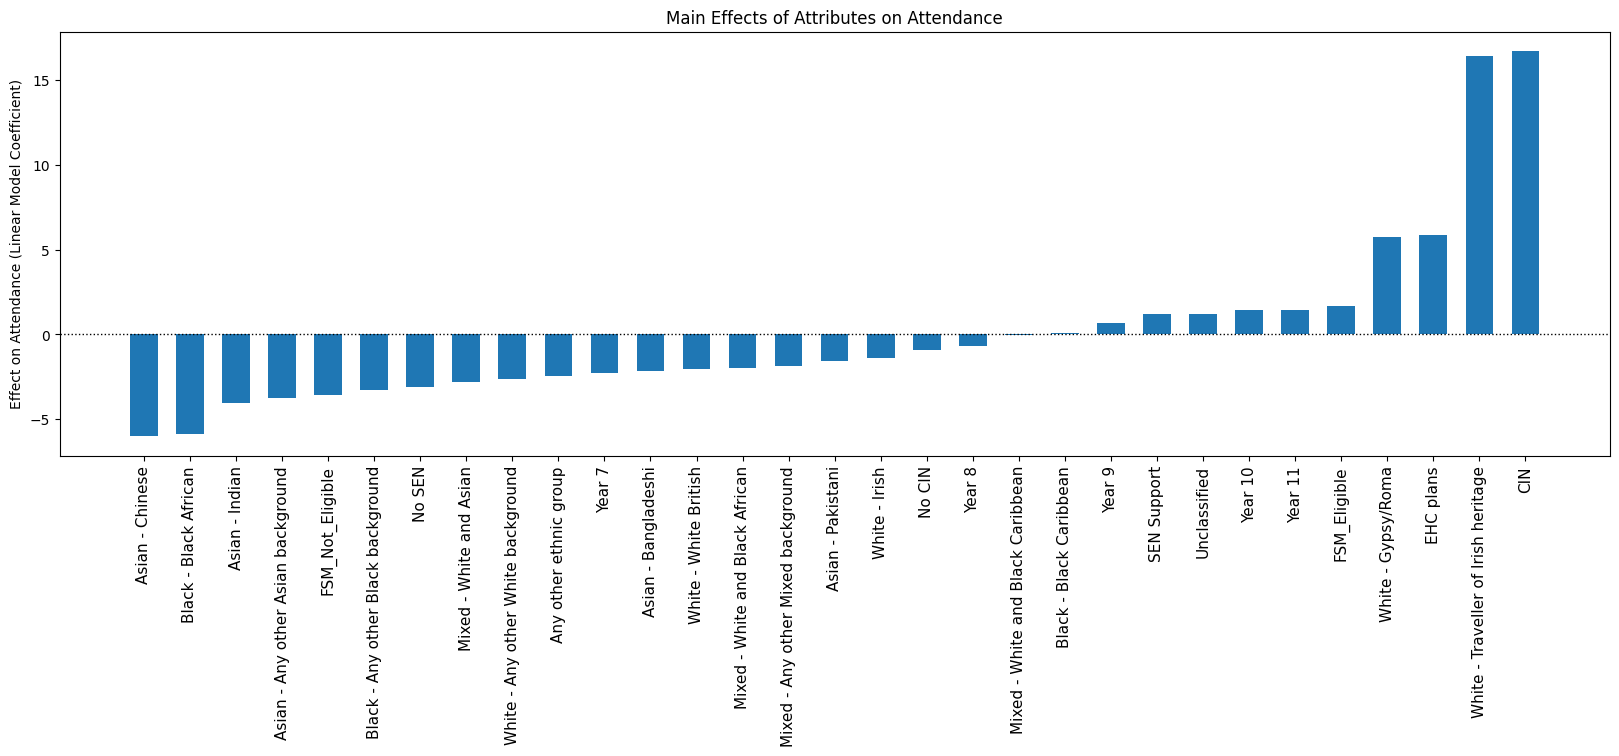

In [433]:
def strip_first_word(label):
    if '_' in label:
        return label.split('_', 1)[1]
    elif ' ' in label:
        return label.split(' ', 1)[1]
    else:
        return label

sorted_beta = beta.sort_values()
labels = [strip_first_word(label) for label in sorted_beta.index]

x = np.arange(len(labels))
plt.figure(figsize=(20, 8))
plt.bar(x, sorted_beta.values, width=0.6)
plt.title('Main Effects of Attributes on Attendance')
plt.ylabel('Effect on Attendance (Linear Model Coefficient)')
plt.xticks(x, labels, rotation=90, ha='center', fontsize=11)
plt.subplots_adjust(bottom=0.35)
plt.axhline(0, color='black', linestyle='dotted', linewidth=1)
plt.savefig("attribute_effects.png", dpi=600, bbox_inches='tight')
plt.show()

## Validation

In [434]:
rows   = []
summaries = []

for var, orig_raw in [
    ('Year',      att_year),
    ('FSM',       att_fsm),
    ('SEN',       att_sen),
    ('CIN',       att_cin),
    ('Ethnicity', att_eth),
]:
    # Shape
    orig = orig_raw
    if isinstance(orig, pd.DataFrame):
        orig = orig.iloc[:,0]
    orig.name = 'original'

    # Synthetic means
    synth = student_synth_df.groupby(var)['Attendance'].mean()
    synth.name = 'synthetic'

    # Match categories between actual and synthetic
    synth = synth.reindex(orig.index)

    # Comparison table
    cmp = pd.DataFrame({
        'original':  orig,
        'synthetic': synth
    })
    # Absolute difference
    cmp['abs_diff'] = (cmp['synthetic'] - cmp['original']).abs()

    # Per category rows
    for cat, row in cmp.iterrows():
        rows.append({
            'margin':    var,
            'category':  cat,
            'original':  row['original'],
            'synthetic': row['synthetic'],
            'abs_diff':  row['abs_diff']
        })

    # Keep valid values
    valid = cmp['abs_diff'].dropna()
    err   = (cmp['synthetic'] - cmp['original']).dropna()

    summaries.append({
        'margin': var,
        'MAE':    valid.mean(),
        'RMSE':   np.sqrt((err**2).mean()),
        'Max':    valid.max()
    })

# Final comparisons
detail_df = (
    pd.DataFrame(rows)
      .set_index(['margin','category'])
      .sort_index()
      .round(6)
)

summary_df = (
    pd.DataFrame(summaries)
      .set_index('margin')
      .round(6)
)

print("Per‐category comparison")
display(detail_df)

print("Overall summary metrics")
display(summary_df)


Per‐category comparison


original  synthetic  abs_diff
margin    category                                                          
CIN       CIN                                  25.90000  25.900000  0.000000
          No CIN                                8.23502   8.236057  0.001036
Ethnicity Any other ethnic group                6.70943   8.496967  1.787537
          Asian - Any other Asian background    5.39652   7.156676  1.760156
          Asian - Bangladeshi                   6.99454   9.214694  2.220154
          Asian - Chinese                       3.15644   4.916596  1.760156
          Asian - Indian                        5.15093   6.911086  1.760156
          Asian - Pakistani                     7.61233   9.372486  1.760156
          Black - Any other Black background    5.90740   7.667556  1.760156
          Black - Black African                 3.31392   5.108276  1.794356
          Black - Black Caribbean               9.23977  11.228962  1.989192
          Mixed - Any other Mixed background    7.31829   9.078446  1.760156
          Mixed - White and Asian               6.36043   8.120586  1.760156
          Mixed - White and Black African       7.20995   8.970106  1.760156
          Mixed - White and Black Caribbean     9.11538  10.875536  1.760156
          Unclassified                         10.38931  12.149466  1.760156
          White - Any other White background    6.56788   8.328036  1.760156
          White - Gypsy/Roma                   14.91503  16.675186  1.760156
          White - Irish                         7.80169   9.561846  1.760156
          White - Traveller of Irish heritage  25.60258  27.362736  1.760156
          White - White British                 7.11342   8.873576  1.760156
FSM       FSM_Eligible                         10.85446  12.608649  1.754189
          FSM_Not_Eligible                      5.58078   7.335237  1.754457
SEN       EHC plans                            15.01680  16.835076  1.818276
          No SEN                                6.08592   7.905393  1.819473
          SEN Support                          10.37620  12.194609  1.818409
Year      Year 10                              10.61938  10.145024  0.474356
          Year 11                              10.62465  10.150127  0.474523
          Year 7                                6.90552   6.434147  0.471373
          Year 8                                8.49124   8.018163  0.473077
          Year 9                                9.83569   9.361543  0.474147

Overall summary metrics


,MAE,RMSE,Max
margin,,,
Year,0.473495,0.473496,0.474523
FSM,1.754323,1.754323,1.754457
SEN,1.818720,1.818720,1.819473
CIN,0.000518,0.000733,0.001036
Ethnicity,1.799662,1.803114,2.220154


## Absense to Attendance

In [435]:
# Convert absence to attendance
student_synth_df['Attendance'] = (100 - student_synth_df['Attendance']).round(1)
student_synth_df.head(5)

,Year,Gender,Ethnicity,FSM,SEN,Suspended,CIN,Noise,PreRake_Attendance,Attendance,Rake_Adjustment
0,Year 8,Male,White - White British,FSM_Not_Eligible,SEN Support,Not Suspended,No CIN,-0.989336,2.110434,92.751251,5.138315
1,Year 11,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN,1.515503,2.458403,90.76658,6.775018
2,Year 10,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN,0.050789,0.988419,92.33189,6.679691
3,Year 10,Female,White - White British,FSM_Eligible,No SEN,Not Suspended,No CIN,0.119409,6.330719,87.637043,6.032239
4,Year 7,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN,-3.102431,0,95.201604,4.798396


In [436]:
student_synth_df['Attendance'].nunique()

27369

# Final Data Processing

In [437]:
# Drop 'Noise' and 'Rake' columns
cols_to_drop = ['Noise'] + [col for col in student_synth_df.columns if 'Rake' in col]
student_synth_df = student_synth_df.drop(columns=cols_to_drop)

# Insert 'Local Authority' as the first column
student_synth_df.insert(0, 'Local Authority', 'Derbyshire')

# Round 'Attendance' to 2 decimal places
student_synth_df['Attendance'] = student_synth_df['Attendance'].round(2)


# Check the result
display(student_synth_df.head())

,Local Authority,Year,Gender,Ethnicity,FSM,SEN,Suspended,CIN,Attendance
0,Derbyshire,Year 8,Male,White - White British,FSM_Not_Eligible,SEN Support,Not Suspended,No CIN,92.751251
1,Derbyshire,Year 11,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN,90.76658
2,Derbyshire,Year 10,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN,92.33189
3,Derbyshire,Year 10,Female,White - White British,FSM_Eligible,No SEN,Not Suspended,No CIN,87.637043
4,Derbyshire,Year 7,Male,White - White British,FSM_Not_Eligible,No SEN,Not Suspended,No CIN,95.201604


# Download Synthetic Data to CSV format

In [439]:
student_synth_df.to_csv('student_profiles.csv')

# References

## Data Sources and Associated Pivot Tables

- **Schools, pupils and their characteristics**  
  *Pupil characteristics - number of pupils by national curriculum year group and set*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/610ca52e-c36b-4dd0-a375-08d8de33d0bf)  
  *Pivot Table(s):* **Year Group x Gender**  
  *2023/24*

- **Schools, pupils and their characteristics**  
  *Pupil characteristics - number of pupils by ethnicity and language*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/49a960ba-f243-4425-a376-08d8de33d0bf)  
  *Pivot Table(s):* **Overall Ethnicity**  
  *2023/24*

- **Schools, pupils and their characteristics**  
  *Pupil characteristics - number of pupils by FSM eligibility*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/fb6c65cb-79b7-4a20-a377-08d8de33d0bf)  
  *Pivot Table(s):* **FSM**  
  *2023/24*

- **Schools, pupils and their characteristics**  
  *FSM eligibility by Ethnicity or national curriculum year group*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/aa818fe7-2713-4578-a378-08d8de33d0bf)  
  *Pivot Table(s):* **FSM × Ethnicity**  
  *2023/24*

- **Schools, pupils and their characteristics**  
  *FSM eligibility by Ethnicity or national curriculum year group*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/977f2bd4-2301-47f5-a309-08d8de33d0bf)  
  *Pivot Table(s):* **FSM × Year Group**  
  *2023/24*

- **Special educational needs in England**  
  *Age and Gender, by type of SEN provision and type of need - 2016 to 2024*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/98e36b70-9248-4f21-11fb-08d8de826934)  
  *Pivot Table(s):* **Overall SEN**, **SEN × Gender**  
  *2023/24*

- **Special educational needs in England**  
  *Year group, by type of SEN provision and type of need - 2016 to 2024*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/7eda65c7-c8be-4587-11fc-08d8de826934)  
  *Pivot Table(s):* **SEN × Year Group**  
  *2023/24*

- **Special educational needs in England**  
  *FSM, Ethnicity and Language, by type of SEN provision and type of need - 2016 to 2024*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/1a68f49f-e16a-47c0-a37a-08d8de33d0bf)  
  *Pivot Table(s):* **SEN × Ethnicity**  
  *2023/24*

- **Special educational needs in England**  
  *FSM, Ethnicity and Language, by type of SEN provision and type of need - 2016 to 2024*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/1bba9f3d-192f-427a-a378-08d8de33d0bf)  
  *Pivot Table(s):* **SEN × FSM**  
  *2023/24*

- **Suspensions and permanent exclusions in England**  
  *Suspensions and permanent exclusions - by characteristic*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/20e94534-9a01-4a64-a37c-08d8de33d0bf)  
  *Pivot Table(s):* **Overall Suspensions**, **Suspensions × Gender**  
  *2023/24, Autumn term. Students were recorded to have one or more suspensions.*

- **Suspensions and permanent exclusions in England**  
  *Suspensions and permanent exclusions - by characteristic*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/4f177773-294c-4a76-11fd-08d8de826934)  
  *Pivot Table(s):* **Suspensions × FSM**  
  *2023/24, Autumn term. Students were recorded to have one or more suspensions.*

- **Suspensions and permanent exclusions in England**  
  *Suspensions and permanent exclusions - by characteristic*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/5b5ce39c-7277-44a3-11fe-08d8de826934)  
  *Pivot Table(s):* **Suspensions × SEN**  
  *2023/24, Autumn term. Students were recorded to have one or more suspensions.*

- **Suspensions and permanent exclusions in England**  
  *Suspensions and permanent exclusions - by characteristic*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/0b85b420-d6ee-44b3-a37d-08d8de33d0bf)  
  *Pivot Table(s):* **Suspensions × Year Group**  
  *2023/24, Autumn term. Students were recorded to have one or more suspensions.*

- **Suspensions and permanent exclusions in England**  
  *Suspensions and permanent exclusions - by characteristic*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/08331f86-fc65-4508-a37e-08d8de33d0bf)  
  *Pivot Table(s):* **Suspensions × Ethnicity**  
  *2023/24, Autumn term. Students were recorded to have one or more suspensions.*

- **Children in need**  
  *A7 National time series of children in need by Gender, age and Ethnicity*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/4f261d06-c594-493a-11ff-08d8de826934)  
  *Pivot Table(s):* **Overall CIN**, **CIN × Gender**  
  *2023-2024, Data is only available at a national level.*

- **Pupil absence in schools in England**  
  *Absence by pupil characteristics*  
  [link](https://explore-education-statistics.service.gov.uk/data-tables/permalink/9430e269-f43-45b9-a40e-08d8de33d0bf)  
  *Pivot Table(s):* **Attendance**  
  *2023/24*


## GIT - CIN Classifier Evaluation
The synthetic student dataset generated in this notebook, based on published distributions from Department for Education (DfE) data, was subsequently used as the basis for all classification and evaluation experiments in this project. All machine learning models (including baseline, logistic regression, decision trees, and gradient boosting classifiers) were trained and evaluated exclusively on the synthetic data to assess the data's utility and fidelity for predictive modeling tasks.

[GIT Repository](https://github.com/mia19reynolds/FinalProject) - under CINPrediction.ipynb